In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import xgboost as xgb

from google.colab import drive
drive.mount('/content/drive')

base_path = '/content/drive/MyDrive/dataset_autoscaling/'
df = pd.read_parquet(os.path.join(base_path, 'nasa_logs_processed.parquet'))

Mounted at /content/drive


In [2]:
# Tạo hàm gom dữ liệu
def resample_data(df, window):
    # Gom nhóm theo thời gian và tính toán các chỉ số
    resampled = df.resample(window).agg({
        'host': 'count',   # Số lượng request (Hits)
        'bytes': 'sum',    # Tổng dung lượng
        'status': lambda x: (x >= 400).sum() # Số lượng lỗi (để tính Error Rate)
    })
    resampled.columns = ['requests', 'total_bytes', 'errors']

    # Xử lý khoảng trống do Bão (01/08 - 03/08) bằng cách điền số 0
    resampled = resampled.fillna(0)
    return resampled

df_1m = resample_data(df, '1min')
df_5m = resample_data(df, '5min')
df_15m = resample_data(df, '15min')
print(len(df_1m))
print(len(df_5m))
print(len(df_15m))

89280
17856
5952


***Dự đoán tải trên mô hình XGBOOST cho 3 khung: 1 phút, 5 phút, 15 phút***

In [3]:
import numpy as np
def enhance_features(df):
    df = df.copy()

    # 1. Đặc trưng thời gian cơ bản
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['is_weekend'] = df.index.dayofweek.isin([5, 6]).astype(int)

    # 2. Time Bins (Chia buổi)
    # 0-5: Đêm, 6-11: Sáng, 12-17: Chiều, 18-23: Tối
    df['part_of_day'] = pd.cut(df['hour'],
                               bins=[-1, 5, 11, 17, 23],
                               labels=[0, 1, 2, 3]).astype(int)

    # 3. Chu kỳ Sin/Cos (Nối liền 23h và 0h)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

    # 4. Lag Features (Quá khứ 1, 2, 3 bước)
    for i in range(1, 4):
        df[f'lag_{i}'] = df['requests'].shift(i)

    # 5. Rolling Stats (Cửa sổ trượt)
    # QUAN TRỌNG: Dùng shift(1) để KHÔNG nhìn thấy tương lai
    window_size = 3
    df_shifted = df['requests'].shift(1)

    df['rolling_mean'] = df_shifted.rolling(window=window_size).mean()
    df['rolling_std'] = df_shifted.rolling(window=window_size).std() # Độ biến động
    df['rolling_max'] = df_shifted.rolling(window=window_size).max() # Đỉnh cao nhất

    # Loại bỏ các dòng NaN đầu tiên do shift
    return df.dropna()

print("Đang tạo đặc trưng...")
# Áp dụng hàm vào dữ liệu 5 phút
df_final = enhance_features(df_5m)
print(f"Kích thước dữ liệu sau xử lý: {df_final.shape}")

Đang tạo đặc trưng...
Kích thước dữ liệu sau xử lý: (17853, 15)


In [ ]:
# 1. Cấu hình ngày cắt
TEST_START_DATE = '1995-08-23 00:00:00'  # Test bắt đầu từ đây (Theo đề)
VALID_START_DATE = '1995-08-16 00:00:00' # Lấy 1 tuần trước đó làm Valid

# 2. Tách tập TEST (Để riêng, không đụng vào)
mask_test = df_final.index >= TEST_START_DATE
test_data = df_final.loc[mask_test]

# 3. Tách tập TRAIN FULL (Từ đầu đến hết 22/08)
mask_train_full = df_final.index < TEST_START_DATE
train_full_data = df_final.loc[mask_train_full]

# 4. Chia nhỏ TRAIN FULL thành TRAIN SUB và VALID (Để tìm tham số)
mask_valid = train_full_data.index >= VALID_START_DATE
valid_sub_data = train_full_data.loc[mask_valid]         # Tuần 16/08 - 22/08

mask_train_sub = train_full_data.index < VALID_START_DATE
train_sub_data = train_full_data.loc[mask_train_sub]     # Từ đầu - 15/08

# 5. Xác định Features và Target
features = ['hour', 'dayofweek', 'is_weekend', 'part_of_day',
            'hour_sin', 'hour_cos', 'lag_1', 'lag_2', 'lag_3',
            'rolling_mean', 'rolling_std', 'rolling_max']
target = 'requests'

# Tạo các biến X, y tương ứng
X_train_sub = train_sub_data[features]
y_train_sub = train_sub_data[target]

X_val = valid_sub_data[features]
y_val = valid_sub_data[target]

X_train_full = train_full_data[features]
y_train_full = train_full_data[target]

X_test = test_data[features]
y_test = test_data[target]

print(f"Cấu hình chia tập:")
print(f"1. Train Sub (Học): {X_train_sub.shape} | Đến 15/08")
print(f"2. Valid (Chỉnh):   {X_val.shape}  | 16/08 -> 22/08")
print(f"3. Train Full (Gộp):{X_train_full.shape} | Từ đầu -> 22/08")
print(f"4. Test (Nộp bài):  {X_test.shape}  | 23/08 -> Hết")

Cấu hình chia tập:
1. Train Sub (Học): (13245, 12) | Đến 15/08
2. Valid (Chỉnh):   (2016, 12)  | 16/08 -> 22/08
3. Train Full (Gộp):(15261, 12) | Từ đầu -> 22/08
4. Test (Nộp bài):  (2592, 12)  | 23/08 -> Hết


In [ ]:
print("Đang chạy Pha 1: Tìm điểm dừng tối ưu...")

# Đưa early_stopping_rounds vào trong hàm khởi tạo (Constructor)
model_tuning = xgb.XGBRegressor(
    n_estimators=5000,
    learning_rate=0.01,
    max_depth=6,
    random_state=42,
    n_jobs=-1,
    objective='reg:squarederror',
    early_stopping_rounds=50
)

model_tuning.fit(
    X_train_sub, y_train_sub,
    eval_set=[(X_train_sub, y_train_sub), (X_val, y_val)],
    verbose=100
)

best_num_trees = model_tuning.best_iteration
print(f"\nĐã tìm ra số cây tối ưu: {best_num_trees}")

Đang chạy Pha 1: Tìm điểm dừng tối ưu...
[0]	validation_0-rmse:146.86457	validation_1-rmse:100.75805
[100]	validation_0-rmse:70.65400	validation_1-rmse:54.77069
[200]	validation_0-rmse:50.64363	validation_1-rmse:45.88064
[300]	validation_0-rmse:46.33733	validation_1-rmse:45.03785
[368]	validation_0-rmse:45.39296	validation_1-rmse:45.06546

Đã tìm ra số cây tối ưu: 318


In [ ]:
print(f"Đang chạy Pha 2: Huấn luyện lại trên {X_train_full.shape[0]} dòng...")

# 1. Khởi tạo mô hình
final_model = xgb.XGBRegressor(
    n_estimators=best_num_trees, # <--- Dùng con số vừa tìm được
    learning_rate=0.01,
    max_depth=6,
    random_state=42,
    n_jobs=-1,
    objective='reg:squarederror'
)

# 2. Fit trên tập TRAIN FULL (Train Sub + Valid)
final_model.fit(X_train_full, y_train_full, verbose=False)

# 3. Dự báo trên tập TEST
preds = final_model.predict(X_test)
# Đảm bảo không có số âm (requests thì không âm được)
preds = np.maximum(preds, 0)

print("Đã hoàn tất dự báo!")

Đang chạy Pha 2: Huấn luyện lại trên 15261 dòng...
Đã hoàn tất dự báo!


--- KẾT QUẢ XGBOOST (Khung 5 phút) ---
2. RMSE:     46.7621
3. MSE:      2186.6936
4. MAE:      35.2338
5. MAPE:     30.71%


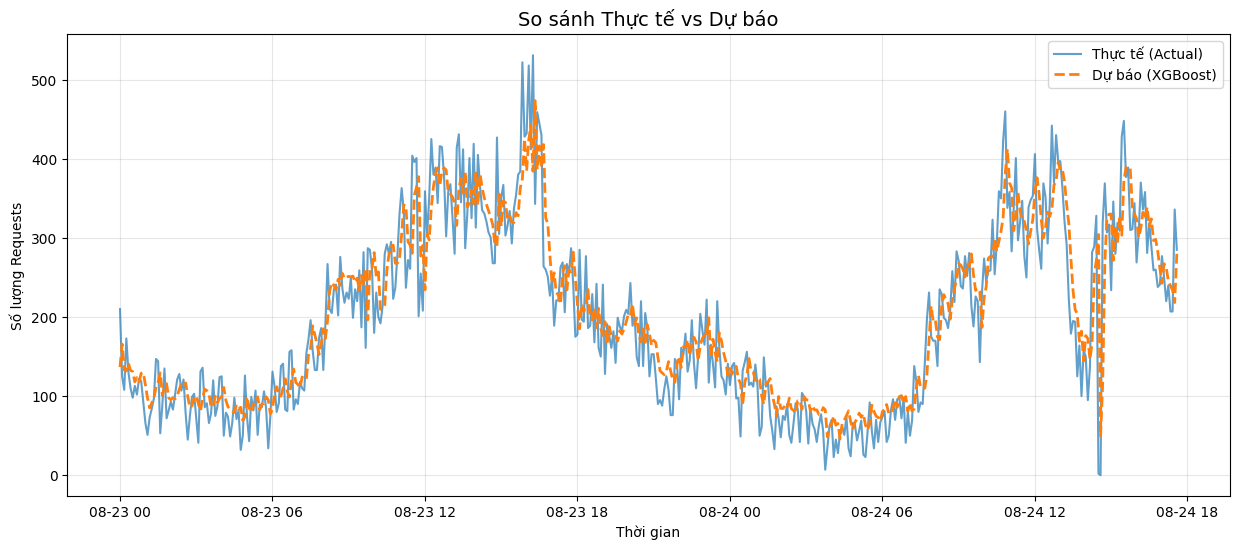

In [ ]:
# --- ĐÁNH GIÁ KẾT QUẢ---
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, preds)
mask = y_test > 0
mape = np.mean(np.abs((y_test[mask] - preds[mask]) / y_test[mask])) * 100

print(f"--- KẾT QUẢ XGBOOST (Khung 5 phút) ---")
print(f"2. RMSE:     {rmse:.4f}")
print(f"3. MSE:      {mse:.4f}")
print(f"4. MAE:      {mae:.4f}")
print(f"5. MAPE:     {mape:.2f}%")

# 2. Vẽ biểu đồ so sánh
plt.figure(figsize=(15, 6))
limit = 500

plt.plot(y_test.index[:limit], y_test[:limit], label='Thực tế (Actual)', color='#1f77b4', alpha=0.7)
plt.plot(y_test.index[:limit], preds[:limit], label='Dự báo (XGBoost)', color='#ff7f0e', linewidth=2, linestyle='--')

plt.title(f'So sánh Thực tế vs Dự báo', fontsize=14) # Thêm chỉ số lên tiêu đề
plt.xlabel('Thời gian')
plt.ylabel('Số lượng Requests')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
print("Đang xử lý dữ liệu 1 PHÚT...")
# Áp dụng hàm enhance_features ở trên vào dữ liệu 1 phút
df_final_1m = enhance_features(df_1m)
print(f"Kích thước dữ liệu 1 phút: {df_final_1m.shape}")

Đang xử lý dữ liệu 1 PHÚT...
Kích thước dữ liệu 1 phút: (89277, 15)


In [ ]:
# 1. Cấu hình ngày cắt
TEST_START_DATE = '1995-08-23 00:00:00'
VALID_START_DATE = '1995-08-16 00:00:00'

# 2. Chia dữ liệu
mask_test = df_final_1m.index >= TEST_START_DATE
test_data = df_final_1m.loc[mask_test]

mask_train_full = df_final_1m.index < TEST_START_DATE
train_full_data = df_final_1m.loc[mask_train_full]

mask_valid = train_full_data.index >= VALID_START_DATE
valid_sub_data = train_full_data.loc[mask_valid]

mask_train_sub = train_full_data.index < VALID_START_DATE
train_sub_data = train_full_data.loc[mask_train_sub]

# 3. Gán Features & Target
features = ['hour', 'dayofweek', 'is_weekend', 'part_of_day',
            'hour_sin', 'hour_cos', 'lag_1', 'lag_2', 'lag_3',
            'rolling_mean', 'rolling_std', 'rolling_max']
target = 'requests'

X_train_sub = train_sub_data[features]
y_train_sub = train_sub_data[target]
X_val = valid_sub_data[features]
y_val = valid_sub_data[target]
X_train_full = train_full_data[features]
y_train_full = train_full_data[target]
X_test = test_data[features]
y_test = test_data[target]

print(f"Cấu hình 1 PHÚT:")
print(f"- Train Full: {X_train_full.shape}")
print(f"- Test:       {X_test.shape}")

Cấu hình 1 PHÚT:
- Train Full: (76317, 12)
- Test:       (12960, 12)


In [ ]:
print("Pha 1: Tìm điểm dừng tối ưu...")

model_tuning_1m = xgb.XGBRegressor(
    n_estimators=5000,
    learning_rate=0.01,
    max_depth=6,
    random_state=42,
    n_jobs=-1,
    objective='reg:squarederror',
    early_stopping_rounds=50
)

model_tuning_1m.fit(
    X_train_sub, y_train_sub,
    eval_set=[(X_train_sub, y_train_sub), (X_val, y_val)],
    verbose=100
)

best_trees_1m = model_tuning_1m.best_iteration
print(f"\nSố cây tối ưu: {best_trees_1m}")

Pha 1: Tìm điểm dừng tối ưu...
[0]	validation_0-rmse:31.48875	validation_1-rmse:22.74677
[100]	validation_0-rmse:17.64228	validation_1-rmse:14.74196
[200]	validation_0-rmse:14.56652	validation_1-rmse:13.39188
[300]	validation_0-rmse:13.97054	validation_1-rmse:13.25865
[367]	validation_0-rmse:13.84363	validation_1-rmse:13.26275

Số cây tối ưu: 317


In [ ]:
print(f"Pha 2: Huấn luyện lại trên {X_train_full.shape[0]} dòng...")

final_model_1m = xgb.XGBRegressor(
    n_estimators=best_trees_1m,
    learning_rate=0.01,
    max_depth=6,
    random_state=42,
    n_jobs=-1,
    objective='reg:squarederror'
)

final_model_1m.fit(X_train_full, y_train_full, verbose=False)

# Dự báo
preds_1m = final_model_1m.predict(X_test)
preds_1m = np.maximum(preds_1m, 0)

print("Đã hoàn tất dự báo 1 phút!")

Pha 2: Huấn luyện lại trên 76317 dòng...
Đã hoàn tất dự báo 1 phút!


--- KẾT QUẢ XGBOOST (Khung 1 phút) ---
2. RMSE:     14.2609
3. MSE:      203.3726
4. MAE:      10.8158
5. MAPE:     48.78%


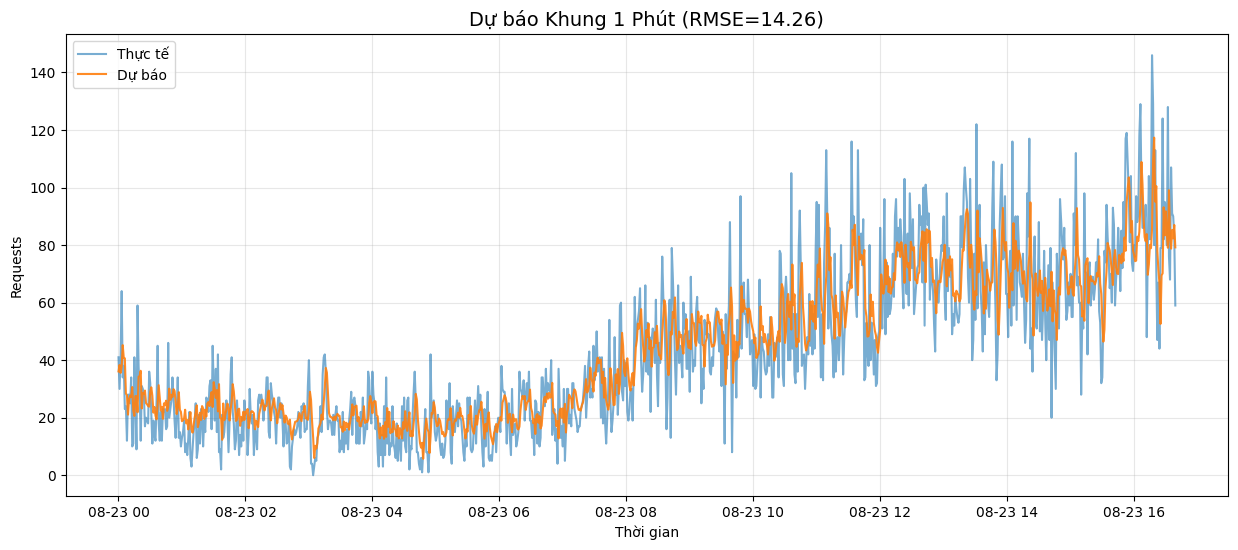

In [ ]:
# Tính chỉ số
mse = mean_squared_error(y_test, preds_1m)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, preds_1m)
mask = y_test > 0
mape = np.mean(np.abs((y_test[mask] - preds_1m[mask]) / y_test[mask])) * 100

print(f"--- KẾT QUẢ XGBOOST (Khung 1 phút) ---")
print(f"2. RMSE:     {rmse:.4f}")
print(f"3. MSE:      {mse:.4f}")
print(f"4. MAE:      {mae:.4f}")
print(f"5. MAPE:     {mape:.2f}%")

# Vẽ biểu đồ
plt.figure(figsize=(15, 6))
limit = 1000 # Vẽ nhiều điểm hơn vì 1 phút rất dày

plt.plot(y_test.index[:limit], y_test[:limit], label='Thực tế', color='#1f77b4', alpha=0.6)
plt.plot(y_test.index[:limit], preds_1m[:limit], label='Dự báo', color='#ff7f0e', linewidth=1.5, alpha=0.9)

plt.title(f'Dự báo Khung 1 Phút (RMSE={rmse:.2f})', fontsize=14)
plt.xlabel('Thời gian')
plt.ylabel('Requests')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
print("Đang xử lý dữ liệu 15 PHÚT...")
df_final_15m = enhance_features(df_15m)
print(f"Kích thước dữ liệu 15 phút: {df_final_15m.shape}")

Đang xử lý dữ liệu 15 PHÚT...
Kích thước dữ liệu 15 phút: (5949, 15)


In [ ]:
# Cấu hình ngày cắt
TEST_START_DATE = '1995-08-23 00:00:00'
VALID_START_DATE = '1995-08-16 00:00:00'

# Chia dữ liệu
mask_test = df_final_15m.index >= TEST_START_DATE
test_data = df_final_15m.loc[mask_test]

mask_train_full = df_final_15m.index < TEST_START_DATE
train_full_data = df_final_15m.loc[mask_train_full]

mask_valid = train_full_data.index >= VALID_START_DATE
valid_sub_data = train_full_data.loc[mask_valid]

mask_train_sub = train_full_data.index < VALID_START_DATE
train_sub_data = train_full_data.loc[mask_train_sub]

# Gán biến
features = ['hour', 'dayofweek', 'is_weekend', 'part_of_day',
            'hour_sin', 'hour_cos', 'lag_1', 'lag_2', 'lag_3',
            'rolling_mean', 'rolling_std', 'rolling_max']
target = 'requests'

X_train_sub = train_sub_data[features]
y_train_sub = train_sub_data[target]
X_val = valid_sub_data[features]
y_val = valid_sub_data[target]
X_train_full = train_full_data[features]
y_train_full = train_full_data[target]
X_test = test_data[features]
y_test = test_data[target]

print(f"Cấu hình 15 PHÚT:")
print(f"- Train Full: {X_train_full.shape}")
print(f"- Test:       {X_test.shape}")

Cấu hình 15 PHÚT:
- Train Full: (5085, 12)
- Test:       (864, 12)


In [ ]:
print("Pha 1: Tìm điểm dừng tối ưu...")

model_tuning_15m = xgb.XGBRegressor(
    n_estimators=5000,
    learning_rate=0.01,
    max_depth=5, # Giảm độ sâu một chút vì dữ liệu ít hơn, tránh học vẹt
    random_state=42,
    n_jobs=-1,
    objective='reg:squarederror',
    early_stopping_rounds=50
)

model_tuning_15m.fit(
    X_train_sub, y_train_sub,
    eval_set=[(X_train_sub, y_train_sub), (X_val, y_val)],
    verbose=100
)

best_trees_15m = model_tuning_15m.best_iteration
print(f"\nSố cây tối ưu: {best_trees_15m}")

Pha 1: Tìm điểm dừng tối ưu...
[0]	validation_0-rmse:428.32097	validation_1-rmse:287.43944
[100]	validation_0-rmse:193.81732	validation_1-rmse:141.33554
[200]	validation_0-rmse:125.93084	validation_1-rmse:107.99576
[300]	validation_0-rmse:109.53137	validation_1-rmse:102.77866
[400]	validation_0-rmse:104.27878	validation_1-rmse:101.97736
[500]	validation_0-rmse:101.26783	validation_1-rmse:101.83122
[517]	validation_0-rmse:100.79671	validation_1-rmse:101.82010

Số cây tối ưu: 467


In [ ]:
print(f"Pha 2: Huấn luyện lại trên {X_train_full.shape[0]} dòng...")

final_model_15m = xgb.XGBRegressor(
    n_estimators=best_trees_15m,
    learning_rate=0.01,
    max_depth=5,
    random_state=42,
    n_jobs=-1,
    objective='reg:squarederror'
)

final_model_15m.fit(X_train_full, y_train_full, verbose=False)

# Dự báo
preds_15m = final_model_15m.predict(X_test)
preds_15m = np.maximum(preds_15m, 0)

print("Đã hoàn tất dự báo 15 phút!")

Pha 2: Huấn luyện lại trên 5085 dòng...
Đã hoàn tất dự báo 15 phút!


--- KẾT QUẢ XGBOOST (Khung 15 phút) ---
2. RMSE:     113.1503
3. MSE:      12802.9795
4. MAE:      82.2061
5. MAPE:     16.75%


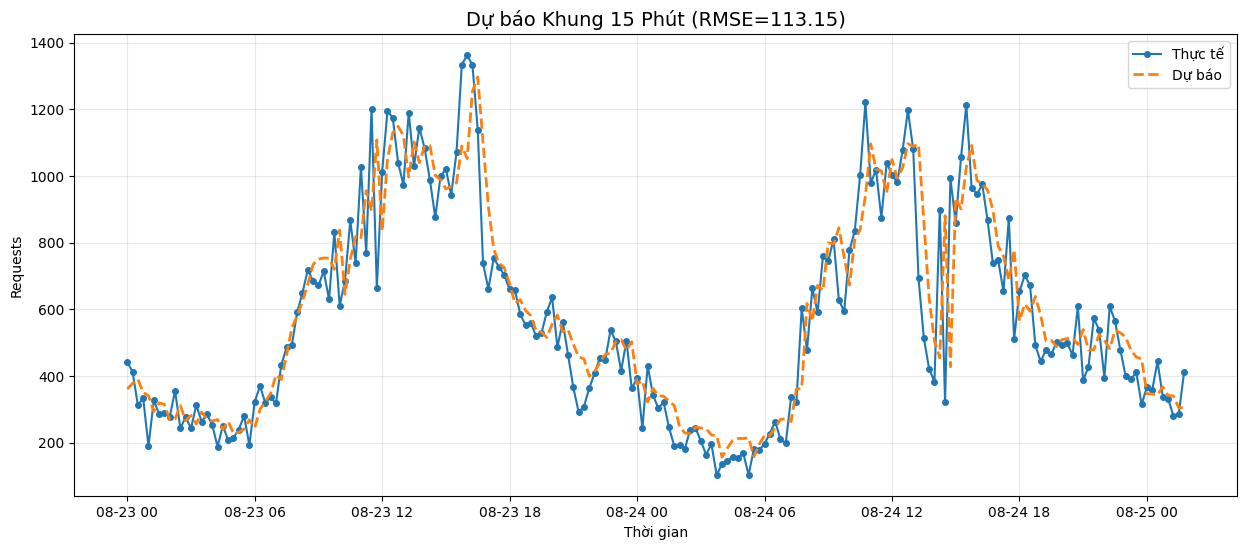

In [ ]:
# Tính chỉ số
mse = mean_squared_error(y_test, preds_15m)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, preds_15m)
mask = y_test > 0
mape = np.mean(np.abs((y_test[mask] - preds_15m[mask]) / y_test[mask])) * 100

print(f"--- KẾT QUẢ XGBOOST (Khung 15 phút) ---")
print(f"2. RMSE:     {rmse:.4f}")
print(f"3. MSE:      {mse:.4f}")
print(f"4. MAE:      {mae:.4f}")
print(f"5. MAPE:     {mape:.2f}%")

# Vẽ biểu đồ
plt.figure(figsize=(15, 6))
limit = 200

plt.plot(y_test.index[:limit], y_test[:limit], label='Thực tế', color='#1f77b4', marker='o', markersize=4)
plt.plot(y_test.index[:limit], preds_15m[:limit], label='Dự báo', color='#ff7f0e', linewidth=2, linestyle='--')

plt.title(f'Dự báo Khung 15 Phút (RMSE={rmse:.2f})', fontsize=14)
plt.xlabel('Thời gian')
plt.ylabel('Requests')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

***Dự đoán tải trên mô hình Prophet cho 3 khung: 1 phút, 5 phút, 15 phút***

In [ ]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Reset index để lấy cột thời gian ra
df_prophet = df_5m.reset_index()

# 2. Đổi tên cột theo luật bất di bất dịch của Prophet (ds và y)
df_prophet = df_prophet.rename(columns={'timestamp': 'ds', 'requests': 'y'})

# 3. LOẠI BỎ MÚI GIỜ (Bắt buộc)
df_prophet['ds'] = df_prophet['ds'].dt.tz_localize(None)

print("Dữ liệu Prophet đã sẵn sàng!")
df_prophet.head()

Dữ liệu Prophet đã sẵn sàng!


,ds,y,total_bytes,errors
0,1995-07-01 00:00:00,301,5277675,1
1,1995-07-01 00:05:00,267,5041043,0
2,1995-07-01 00:10:00,242,6111846,4
3,1995-07-01 00:15:00,282,4559748,4
4,1995-07-01 00:20:00,319,7262385,0


In [ ]:
# Cấu hình ngày cắt
TEST_START_DATE = pd.to_datetime('1995-08-23 00:00:00')
VALID_START_DATE = pd.to_datetime('1995-08-16 00:00:00')

# 1. Tách tập TEST
test_prophet = df_prophet[df_prophet['ds'] >= TEST_START_DATE]

# 2. Tập TRAIN FULL
train_full_prophet = df_prophet[df_prophet['ds'] < TEST_START_DATE]

# 3. Tách nhỏ TRAIN FULL thành TRAIN SUB và VALID (Dùng cho Pha 1)
valid_prophet = train_full_prophet[train_full_prophet['ds'] >= VALID_START_DATE]
train_sub_prophet = train_full_prophet[train_full_prophet['ds'] < VALID_START_DATE]

print(f"📅 Cấu hình chia tập Prophet:")
print(f"- Train Sub:  {train_sub_prophet.shape}")
print(f"- Valid (Pha 1):      {valid_prophet.shape}")
print(f"- Train Full: {train_full_prophet.shape}")
print(f"- Test (Chấm điểm):   {test_prophet.shape}")

📅 Cấu hình chia tập Prophet:
- Train Sub:  (13248, 4)
- Valid (Pha 1):      (2016, 4)
- Train Full: (15264, 4)
- Test (Chấm điểm):   (2592, 4)


In [ ]:
print("Pha 1: Huấn luyện trên Train Sub & Kiểm tra trên Valid...")

# 1. Khởi tạo mô hình
# Có thể chỉnh changepoint_prior_scale ở đây nếu muốn mô hình nhạy hơn
model_p1 = Prophet(daily_seasonality=True, weekly_seasonality=True)

# 2. Train trên tập con
model_p1.fit(train_sub_prophet)

# 3. Dự báo trên tập Valid
future_val = valid_prophet[['ds']]
forecast_val = model_p1.predict(future_val)

# 4. Đánh giá sơ bộ
y_true_val = valid_prophet['y'].values
y_pred_val = np.maximum(forecast_val['yhat'].values, 0) # Chặn số âm

mae_val = mean_absolute_error(y_true_val, y_pred_val)
print(f"Sai số MAE trên tập Valid: {mae_val:.2f}")
print("=> Nếu sai số chấp nhận được, tiến hành Pha 2 (Train Full).")

Pha 1: Huấn luyện trên Train Sub & Kiểm tra trên Valid...


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Sai số MAE trên tập Valid: 49.91
=> Nếu sai số chấp nhận được, tiến hành Pha 2 (Train Full).


In [ ]:
print(f"Pha 2: Huấn luyện lại trên toàn bộ dữ liệu quá khứ ({train_full_prophet.shape[0]} dòng)...")

# 1. Khởi tạo lại mô hình mới tinh
model_final = Prophet(daily_seasonality=True, weekly_seasonality=True)

# 2. Train trên tập FULL (Train Sub + Valid)
model_final.fit(train_full_prophet)

print("Đã huấn luyện xong mô hình cuối cùng!")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Pha 2: Huấn luyện lại trên toàn bộ dữ liệu quá khứ (15264 dòng)...
Đã huấn luyện xong mô hình cuối cùng!


Đang dự báo tập Test...
--- KẾT QUẢ PROPHET (Khung 5 phút) ---
1. RMSE:     83.1327
2. MSE:      6911.0481
3. MAE:      62.7069
4. MAPE:     46.29%


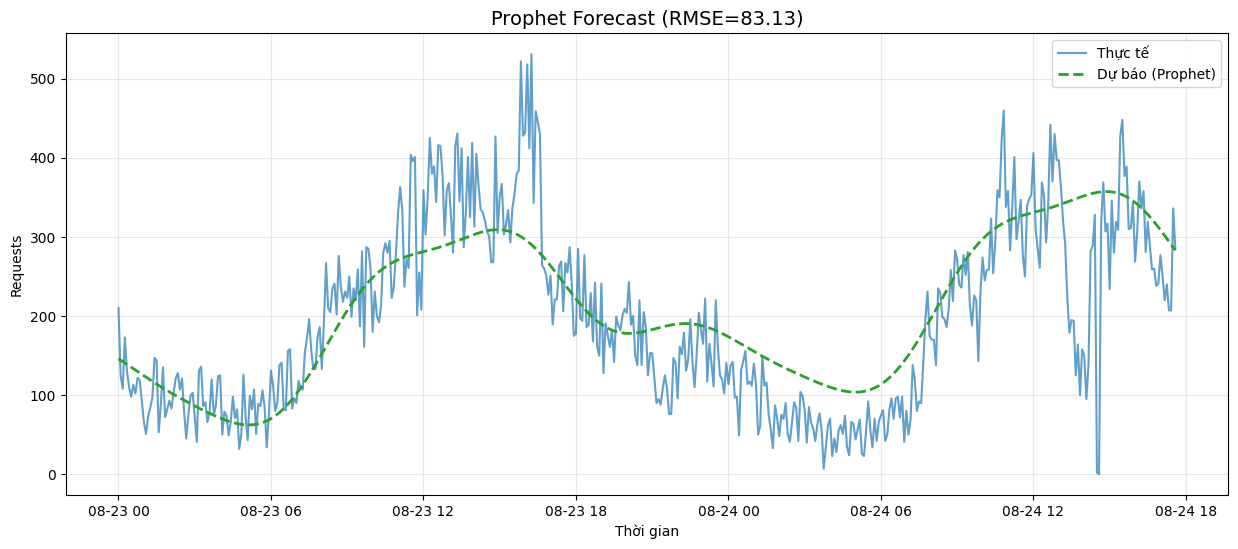

In [ ]:
# 1. Tạo khung thời gian tương lai (chính là các mốc giờ trong tập Test)
future_test = test_prophet[['ds']]

# 2. Dự báo
print("Đang dự báo tập Test...")
forecast_test = model_final.predict(future_test)

# 3. Lấy kết quả
y_true = test_prophet['y'].values
y_pred = forecast_test['yhat'].values
y_pred = np.maximum(y_pred, 0)

# 4. Tính toán chỉ số đánh giá
mse_p = mean_squared_error(y_true, y_pred)
rmse_p = np.sqrt(mse_p)
mae_p = mean_absolute_error(y_true, y_pred)

# MAPE
mask = y_true > 0
mape_p = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

print(f"--- KẾT QUẢ PROPHET (Khung 5 phút) ---")
print(f"1. RMSE:     {rmse_p:.4f}")
print(f"2. MSE:      {mse_p:.4f}")
print(f"3. MAE:      {mae_p:.4f}")
print(f"4. MAPE:     {mape_p:.2f}%")

# 5. Vẽ biểu đồ
plt.figure(figsize=(15, 6))
limit = 500
plt.plot(test_prophet['ds'][:limit], y_true[:limit], label='Thực tế', color='#1f77b4', alpha=0.7)
plt.plot(test_prophet['ds'][:limit], y_pred[:limit], label='Dự báo (Prophet)', color='#2ca02c', linewidth=2, linestyle='--') # Prophet màu xanh lá
plt.title(f'Prophet Forecast (RMSE={rmse_p:.2f})', fontsize=14)
plt.xlabel('Thời gian')
plt.ylabel('Requests')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# 1. Reset index và đổi tên cột
df_prophet_1m = df_1m.reset_index()
df_prophet_1m = df_prophet_1m.rename(columns={'timestamp': 'ds', 'requests': 'y'})

# 2. LOẠI BỎ MÚI GIỜ (Bắt buộc)
df_prophet_1m['ds'] = df_prophet_1m['ds'].dt.tz_localize(None)

print("Dữ liệu Prophet (1 Phút) đã sẵn sàng!")
df_prophet_1m.head()

Dữ liệu Prophet (1 Phút) đã sẵn sàng!


,ds,y,total_bytes,errors
0,1995-07-01 00:00:00,42,608453,0
1,1995-07-01 00:01:00,61,910128,1
2,1995-07-01 00:02:00,57,628556,0
3,1995-07-01 00:03:00,71,1747389,0
4,1995-07-01 00:04:00,70,1383149,0


In [ ]:
# Cấu hình ngày cắt
TEST_START_DATE = pd.to_datetime('1995-08-23 00:00:00')
VALID_START_DATE = pd.to_datetime('1995-08-16 00:00:00')

# 1. Tách tập TEST
test_prophet_1m = df_prophet_1m[df_prophet_1m['ds'] >= TEST_START_DATE]

# 2. Tập TRAIN FULL
train_full_prophet_1m = df_prophet_1m[df_prophet_1m['ds'] < TEST_START_DATE]

# 3. Tách nhỏ TRAIN FULL thành TRAIN SUB và VALID
valid_prophet_1m = train_full_prophet_1m[train_full_prophet_1m['ds'] >= VALID_START_DATE]
train_sub_prophet_1m = train_full_prophet_1m[train_full_prophet_1m['ds'] < VALID_START_DATE]

print(f"Cấu hình chia tập Prophet (1 Phút):")
print(f"- Train Sub:  {train_sub_prophet_1m.shape}")
print(f"- Valid:      {valid_prophet_1m.shape}")
print(f"- Train Full: {train_full_prophet_1m.shape}")
print(f"- Test:       {test_prophet_1m.shape}")

Cấu hình chia tập Prophet (1 Phút):
- Train Sub:  (66240, 4)
- Valid:      (10080, 4)
- Train Full: (76320, 4)
- Test:       (12960, 4)


In [ ]:
print("Pha 1: Huấn luyện trên Train Sub & Kiểm tra trên Valid...")

# 1. Khởi tạo mô hình
model_p1_1m = Prophet(daily_seasonality=True, weekly_seasonality=True)

# 2. Train trên tập con
model_p1_1m.fit(train_sub_prophet_1m)

# 3. Dự báo trên tập Valid
future_val_1m = valid_prophet_1m[['ds']]
forecast_val_1m = model_p1_1m.predict(future_val_1m)

# 4. Đánh giá sơ bộ
y_true_val_1m = valid_prophet_1m['y'].values
y_pred_val_1m = np.maximum(forecast_val_1m['yhat'].values, 0)

mae_val_1m = mean_absolute_error(y_true_val_1m, y_pred_val_1m)
print(f"Sai số MAE trên tập Valid (1 phút): {mae_val_1m:.2f}")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Pha 1: Huấn luyện trên Train Sub & Kiểm tra trên Valid...
Sai số MAE trên tập Valid (1 phút): 13.04


In [ ]:
print(f"Pha 2: Huấn luyện lại trên toàn bộ dữ liệu ({train_full_prophet_1m.shape[0]} dòng)...")

# 1. Khởi tạo lại mô hình mới
model_final_1m = Prophet(daily_seasonality=True, weekly_seasonality=True)

# 2. Train trên tập FULL
model_final_1m.fit(train_full_prophet_1m)

print("Đã huấn luyện xong mô hình 1 phút!")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Pha 2: Huấn luyện lại trên toàn bộ dữ liệu (76320 dòng)...
Đã huấn luyện xong mô hình 1 phút!


Đang dự báo tập Test (1 phút)...
--- KẾT QUẢ PROPHET (Khung 1 Phút) ---
1. RMSE:     21.4350
2. MSE:      459.4577
3. MAE:      15.8917
4. MAPE:     56.40%


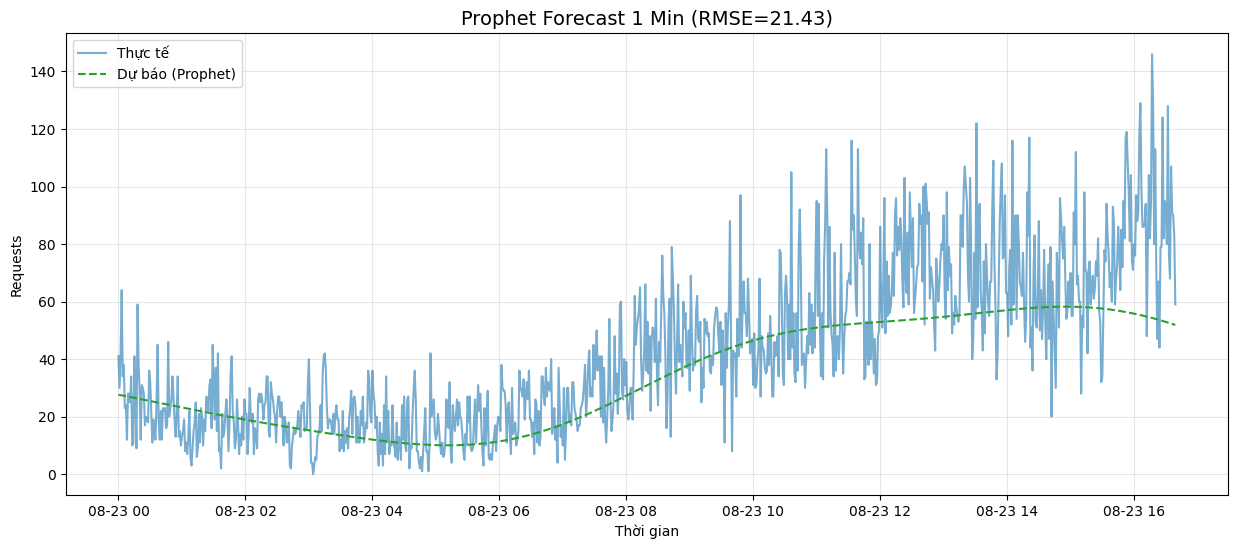

In [ ]:
# 1. Dự báo
print("Đang dự báo tập Test (1 phút)...")
future_test_1m = test_prophet_1m[['ds']]
forecast_test_1m = model_final_1m.predict(future_test_1m)

# 2. Lấy kết quả
y_true_1m = test_prophet_1m['y'].values
y_pred_1m = np.maximum(forecast_test_1m['yhat'].values, 0)

# 3. Tính toán chỉ số
mse_1m = mean_squared_error(y_true_1m, y_pred_1m)
rmse_1m = np.sqrt(mse_1m)
mae_1m = mean_absolute_error(y_true_1m, y_pred_1m)

# MAPE
mask = y_true_1m > 0
mape_1m = np.mean(np.abs((y_true_1m[mask] - y_pred_1m[mask]) / y_true_1m[mask])) * 100

print(f"--- KẾT QUẢ PROPHET (Khung 1 Phút) ---")
print(f"1. RMSE:     {rmse_1m:.4f}")
print(f"2. MSE:      {mse_1m:.4f}")
print(f"3. MAE:      {mae_1m:.4f}")
print(f"4. MAPE:     {mape_1m:.2f}%")

# 4. Vẽ biểu đồ (Vẽ 1000 điểm vì dữ liệu dày)
plt.figure(figsize=(15, 6))
limit = 1000
plt.plot(test_prophet_1m['ds'][:limit], y_true_1m[:limit], label='Thực tế', color='#1f77b4', alpha=0.6)
plt.plot(test_prophet_1m['ds'][:limit], y_pred_1m[:limit], label='Dự báo (Prophet)', color='#2ca02c', linewidth=1.5, linestyle='--')
plt.title(f'Prophet Forecast 1 Min (RMSE={rmse_1m:.2f})', fontsize=14)
plt.xlabel('Thời gian')
plt.ylabel('Requests')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# 1. Reset index và đổi tên
df_prophet_15m = df_15m.reset_index()
df_prophet_15m = df_prophet_15m.rename(columns={'timestamp': 'ds', 'requests': 'y'})

# 2. LOẠI BỎ MÚI GIỜ
df_prophet_15m['ds'] = df_prophet_15m['ds'].dt.tz_localize(None)

print("Dữ liệu Prophet (15 Phút) đã sẵn sàng!")
df_prophet_15m.head()

Dữ liệu Prophet (15 Phút) đã sẵn sàng!


,ds,y,total_bytes,errors
0,1995-07-01 00:00:00,810,16430564,5
1,1995-07-01 00:15:00,945,18046060,5
2,1995-07-01 00:30:00,1006,22420824,4
3,1995-07-01 00:45:00,804,24088038,10
4,1995-07-01 01:00:00,750,17178646,2


In [ ]:
# Cấu hình ngày cắt
TEST_START_DATE = pd.to_datetime('1995-08-23 00:00:00')
VALID_START_DATE = pd.to_datetime('1995-08-16 00:00:00')

# Chia tập
test_prophet_15m = df_prophet_15m[df_prophet_15m['ds'] >= TEST_START_DATE]
train_full_prophet_15m = df_prophet_15m[df_prophet_15m['ds'] < TEST_START_DATE]

valid_prophet_15m = train_full_prophet_15m[train_full_prophet_15m['ds'] >= VALID_START_DATE]
train_sub_prophet_15m = train_full_prophet_15m[train_full_prophet_15m['ds'] < VALID_START_DATE]

print(f"Cấu hình chia tập Prophet (15 Phút):")
print(f"- Train Full: {train_full_prophet_15m.shape}")
print(f"- Test:       {test_prophet_15m.shape}")

Cấu hình chia tập Prophet (15 Phút):
- Train Full: (5088, 4)
- Test:       (864, 4)


In [ ]:
print("Pha 1: Huấn luyện trên Train Sub & Kiểm tra trên Valid...")

model_p1_15m = Prophet(daily_seasonality=True, weekly_seasonality=True)
model_p1_15m.fit(train_sub_prophet_15m)

future_val_15m = valid_prophet_15m[['ds']]
forecast_val_15m = model_p1_15m.predict(future_val_15m)

y_true_val_15m = valid_prophet_15m['y'].values
y_pred_val_15m = np.maximum(forecast_val_15m['yhat'].values, 0)

mae_val_15m = mean_absolute_error(y_true_val_15m, y_pred_val_15m)
print(f"Sai số MAE trên tập Valid (15 phút): {mae_val_15m:.2f}")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Pha 1: Huấn luyện trên Train Sub & Kiểm tra trên Valid...
Sai số MAE trên tập Valid (15 phút): 140.93


In [ ]:
print(f"Pha 2: Huấn luyện lại trên toàn bộ dữ liệu...")

model_final_15m = Prophet(daily_seasonality=True, weekly_seasonality=True)
model_final_15m.fit(train_full_prophet_15m)

print("Đã huấn luyện xong mô hình 15 phút!")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Pha 2: Huấn luyện lại trên toàn bộ dữ liệu...
Đã huấn luyện xong mô hình 15 phút!


Đang dự báo tập Test (15 phút)...
--- KẾT QUẢ PROPHET (Khung 15 Phút) ---
1. RMSE:     222.4282
2. MSE:      49474.2886
3. MAE:      169.3509
4. MAPE:     34.62%


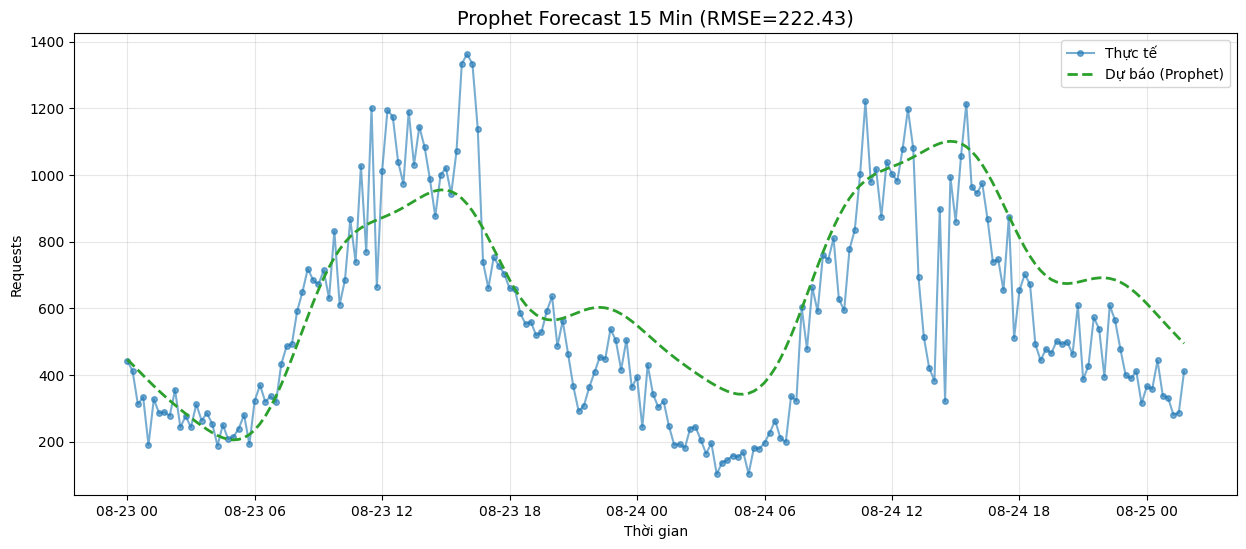

In [ ]:
# 1. Dự báo
print("Đang dự báo tập Test (15 phút)...")
future_test_15m = test_prophet_15m[['ds']]
forecast_test_15m = model_final_15m.predict(future_test_15m)

# 2. Lấy kết quả
y_true_15m = test_prophet_15m['y'].values
y_pred_15m = np.maximum(forecast_test_15m['yhat'].values, 0)

# 3. Tính toán chỉ số
mse_15m = mean_squared_error(y_true_15m, y_pred_15m)
rmse_15m = np.sqrt(mse_15m)
mae_15m = mean_absolute_error(y_true_15m, y_pred_15m)

# MAPE
mask = y_true_15m > 0
mape_15m = np.mean(np.abs((y_true_15m[mask] - y_pred_15m[mask]) / y_true_15m[mask])) * 100

print(f"--- KẾT QUẢ PROPHET (Khung 15 Phút) ---")
print(f"1. RMSE:     {rmse_15m:.4f}")
print(f"2. MSE:      {mse_15m:.4f}")
print(f"3. MAE:      {mae_15m:.4f}")
print(f"4. MAPE:     {mape_15m:.2f}%")

# 4. Vẽ biểu đồ (Vẽ 200 điểm thôi cho dễ nhìn)
plt.figure(figsize=(15, 6))
limit = 200
plt.plot(test_prophet_15m['ds'][:limit], y_true_15m[:limit], label='Thực tế', color='#1f77b4', marker='o', markersize=4, alpha=0.6)
plt.plot(test_prophet_15m['ds'][:limit], y_pred_15m[:limit], label='Dự báo (Prophet)', color='#2ca02c', linewidth=2, linestyle='--')
plt.title(f'Prophet Forecast 15 Min (RMSE={rmse_15m:.2f})', fontsize=14)
plt.xlabel('Thời gian')
plt.ylabel('Requests')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Đặt seed để kết quả không bị nhảy lung tung mỗi lần chạy
tf.random.set_seed(42)
np.random.seed(42)

# 1. Lấy dữ liệu và xử lý Timezone
df_lstm = df_5m.copy()
if df_lstm.index.tz is not None:
    df_lstm.index = df_lstm.index.tz_localize(None)

dataset = df_lstm[['requests']].values.astype('float32')

# 2. Hàm tạo chuỗi (Sliding Window)
def create_dataset(dataset, look_back=12):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# 3. Xác định điểm cắt (Index)
# Valid từ 16/08, Test từ 23/08
VALID_START_DATE = '1995-08-16 00:00:00'
TEST_START_DATE = '1995-08-23 00:00:00'

idx_valid = len(df_lstm[df_lstm.index < VALID_START_DATE])
idx_test = len(df_lstm[df_lstm.index < TEST_START_DATE])

print(f"Cắt Valid tại dòng: {idx_valid}")
print(f"Cắt Test tại dòng:  {idx_test}")

Cắt Valid tại dòng: 13248
Cắt Test tại dòng:  15264


In [ ]:
print("PHA 1: Tuning trên tập Valid...")

# 1. Chuẩn hóa dữ liệu (Chỉ fit trên tập Train Sub để tránh lộ đề)
scaler_sub = MinMaxScaler(feature_range=(0, 1))
train_sub = dataset[:idx_valid]
valid = dataset[idx_valid:idx_test]

# Fit scaler trên train_sub và transform cả 2
train_sub_scaled = scaler_sub.fit_transform(train_sub)
valid_scaled = scaler_sub.transform(valid)

# 2. Tạo Window (Look back 12 = 60 phút)
look_back = 12
X_sub, y_sub = create_dataset(train_sub_scaled, look_back)
X_val, y_val = create_dataset(valid_scaled, look_back)

# Reshape cho LSTM [Samples, Time Steps, Features]
X_sub = np.reshape(X_sub, (X_sub.shape[0], X_sub.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

# 3. Xây dựng mô hình tìm kiếm
model_tuning = Sequential()
model_tuning.add(LSTM(100, return_sequences=False, input_shape=(look_back, 1)))
model_tuning.add(Dense(1))
model_tuning.compile(loss='mean_squared_error', optimizer='adam')

# 4. Dùng Early Stopping (Tự động dừng khi Valid không tốt lên)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train thử
history = model_tuning.fit(X_sub, y_sub,
                           validation_data=(X_val, y_val),
                           epochs=50, batch_size=32, verbose=1,
                           callbacks=[early_stop])

# Lưu lại số epoch tốt nhất
best_epoch = early_stop.stopped_epoch if early_stop.stopped_epoch > 0 else 50
print(f"Số Epoch tối ưu tìm được: {best_epoch}")

PHA 1: Tuning trên tập Valid...
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


414/414 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0024 - val_loss: 9.3519e-04
Epoch 2/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0012 - val_loss: 8.9785e-04
Epoch 3/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0011 - val_loss: 8.7971e-04
Epoch 4/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0011 - val_loss: 8.7561e-04
Epoch 5/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0011 - val_loss: 8.7783e-04
Epoch 6/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0011 - val_loss: 8.7968e-04
Epoch 7/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0011 - val_loss: 8.8053e-04
Epoch 8/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0011 - val_loss: 8.8042e-04
Epoch 9/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0011 - val_loss: 8.8007e-04
Số Epoch tối ưu tìm được: 8


In [ ]:
print(f"PHA 2: Huấn luyện lại trên toàn bộ Train ({best_epoch} vòng)...")

# 1. Chuẩn hóa lại trên toàn bộ tập Train Full (Từ đầu đến trước ngày 23/08)
scaler_full = MinMaxScaler(feature_range=(0, 1))
train_full = dataset[:idx_test]
test_data = dataset[idx_test:]

train_full_scaled = scaler_full.fit_transform(train_full)
test_scaled = scaler_full.transform(test_data)

# 2. Tạo dữ liệu train full và test
X_train_full, y_train_full = create_dataset(train_full_scaled, look_back)
X_test, y_test = create_dataset(test_scaled, look_back)

# Reshape
X_train_full = np.reshape(X_train_full, (X_train_full.shape[0], X_train_full.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# 3. Khởi tạo và Train lại mô hình chính thức
model_final = Sequential()
model_final.add(LSTM(100, return_sequences=False, input_shape=(look_back, 1)))
model_final.add(Dense(1))
model_final.compile(loss='mean_squared_error', optimizer='adam')

# Train đúng số best_epoch vòng (không cần valid nữa)
model_final.fit(X_train_full, y_train_full, epochs=best_epoch, batch_size=32, verbose=0)

PHA 2: Huấn luyện lại trên toàn bộ Train (8 vòng)...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Đang dự báo...
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
--- KẾT QUẢ LSTM (Refitted - 5 Phút) ---
1. MAE:  36.02
2. MSE:  2227.70
3. RMSE: 47.20
4. MAPE: 31.81%


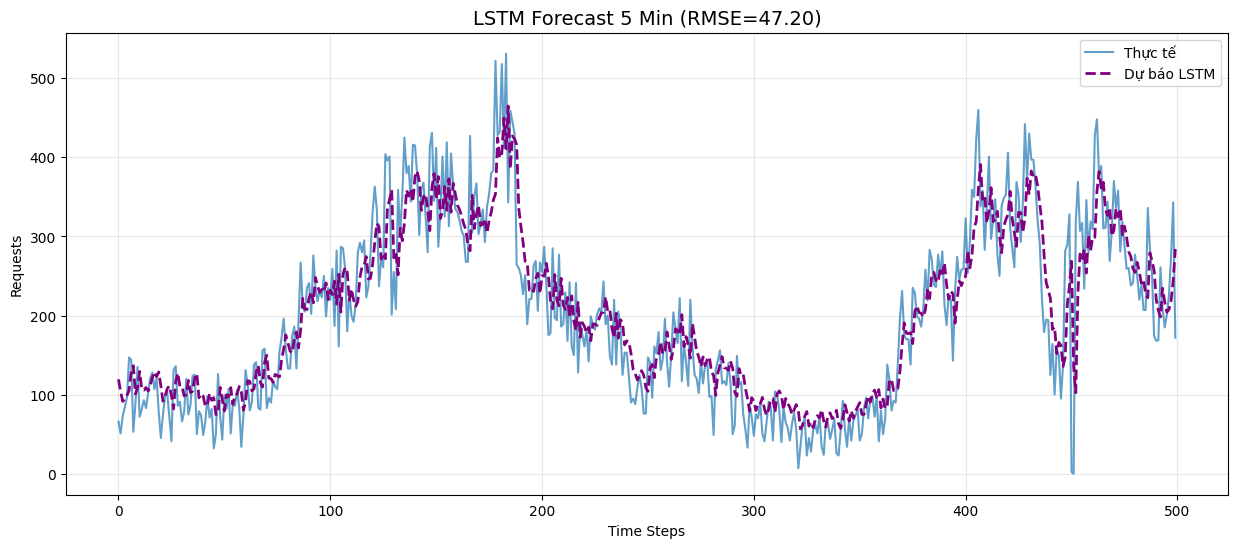

In [ ]:
# 4. Dự báo
print("Đang dự báo...")
test_predict = model_final.predict(X_test)

# Đảo ngược chuẩn hóa
test_predict_inv = scaler_full.inverse_transform(test_predict)
y_test_inv = scaler_full.inverse_transform([y_test])

# 5. Đánh giá
y_true = y_test_inv[0]
y_pred = test_predict_inv[:, 0]

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

# Tính MAPE
mask = y_true > 0
mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

print(f"--- KẾT QUẢ LSTM (Refitted - 5 Phút) ---")
print(f"1. MAE:  {mae:.2f}")
print(f"2. MSE:  {mse:.2f}")
print(f"3. RMSE: {rmse:.2f}")
print(f"4. MAPE: {mape:.2f}%")

plt.figure(figsize=(15, 6))
limit = 500
plt.plot(y_true[:limit], label='Thực tế', color='#1f77b4', alpha=0.7)
plt.plot(y_pred[:limit], label='Dự báo LSTM', color='purple', linewidth=2, linestyle='--')
plt.title(f'LSTM Forecast 5 Min (RMSE={rmse:.2f})', fontsize=14)
plt.xlabel('Time Steps')
plt.ylabel('Requests')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# --- 1. Lấy dữ liệu 1 phút ---
df_lstm_1m = df_1m.copy()
if df_lstm_1m.index.tz is not None:
    df_lstm_1m.index = df_lstm_1m.index.tz_localize(None)

dataset_1m = df_lstm_1m[['requests']].values.astype('float32')

# --- 2. Xác định điểm cắt ---
VALID_START_DATE = '1995-08-16 00:00:00'
TEST_START_DATE = '1995-08-23 00:00:00'

idx_valid = len(df_lstm_1m[df_lstm_1m.index < VALID_START_DATE])
idx_test = len(df_lstm_1m[df_lstm_1m.index < TEST_START_DATE])

print(f"Cắt Valid tại dòng: {idx_valid}")
print(f"Cắt Test tại dòng:  {idx_test}")

Cắt Valid tại dòng: 66240
Cắt Test tại dòng:  76320


In [ ]:
print("PHA 1: Tuning trên tập Valid...")

# 1. Chuẩn hóa (Fit trên Train Sub)
scaler_sub = MinMaxScaler(feature_range=(0, 1))
train_sub = dataset_1m[:idx_valid]
valid = dataset_1m[idx_valid:idx_test]

train_sub_scaled = scaler_sub.fit_transform(train_sub)
valid_scaled = scaler_sub.transform(valid)

# 2. Tạo Window (Look back 30 = 30 phút quá khứ)
look_back = 30
X_sub, y_sub = create_dataset(train_sub_scaled, look_back)
X_val, y_val = create_dataset(valid_scaled, look_back)

X_sub = np.reshape(X_sub, (X_sub.shape[0], X_sub.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

# 3. Model Tuning
model_tuning = Sequential()
model_tuning.add(LSTM(100, return_sequences=False, input_shape=(look_back, 1)))
model_tuning.add(Dense(1))
model_tuning.compile(loss='mean_squared_error', optimizer='adam')

# Dừng sớm (Patience=3 vì dữ liệu 1 phút biến động nhanh)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Batch size 128 để chạy nhanh hơn với dữ liệu lớn
model_tuning.fit(X_sub, y_sub,
                 validation_data=(X_val, y_val),
                 epochs=20, batch_size=128, verbose=1,
                 callbacks=[early_stop])

best_epoch_1m = early_stop.stopped_epoch if early_stop.stopped_epoch > 0 else 20
print(f"Số Epoch tối ưu (1m): {best_epoch_1m}")

PHA 1: Tuning trên tập Valid...
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


518/518 ━━━━━━━━━━━━━━━━━━━━ 41s 76ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 2/20
518/518 ━━━━━━━━━━━━━━━━━━━━ 33s 63ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 3/20
518/518 ━━━━━━━━━━━━━━━━━━━━ 28s 55ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 4/20
518/518 ━━━━━━━━━━━━━━━━━━━━ 32s 61ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 5/20
518/518 ━━━━━━━━━━━━━━━━━━━━ 28s 54ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 6/20
518/518 ━━━━━━━━━━━━━━━━━━━━ 28s 54ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 7/20
518/518 ━━━━━━━━━━━━━━━━━━━━ 28s 54ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 8/20
518/518 ━━━━━━━━━━━━━━━━━━━━ 29s 55ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 9/20
518/518 ━━━━━━━━━━━━━━━━━━━━ 28s 54ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 10/20
518/518 ━━━━━━━━━━━━━━━━━━━━ 29s 56ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 11/20
518/518 ━━━━━━━━━━━━━━━━━━━━ 48s 70ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 12/20
518/518 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
print(f"PHA 2: Huấn luyện lại ({best_epoch_1m} vòng)...")

# 1. Chuẩn hóa Full
scaler_full = MinMaxScaler(feature_range=(0, 1))
train_full = dataset_1m[:idx_test]
test_data = dataset_1m[idx_test:]

train_full_scaled = scaler_full.fit_transform(train_full)
test_scaled = scaler_full.transform(test_data)

# 2. Tạo dataset Full
X_train_full, y_train_full = create_dataset(train_full_scaled, look_back)
X_test, y_test = create_dataset(test_scaled, look_back)

X_train_full = np.reshape(X_train_full, (X_train_full.shape[0], X_train_full.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# 3. Train Final
model_final = Sequential()
model_final.add(LSTM(100, return_sequences=False, input_shape=(look_back, 1)))
model_final.add(Dense(1))
model_final.compile(loss='mean_squared_error', optimizer='adam')

model_final.fit(X_train_full, y_train_full, epochs=best_epoch_1m, batch_size=128, verbose=1)

PHA 2: Huấn luyện lại (20 vòng)...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 37s 52ms/step - loss: 0.0017
Epoch 2/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 29s 49ms/step - loss: 0.0012
Epoch 3/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 29s 49ms/step - loss: 0.0012
Epoch 4/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 30s 51ms/step - loss: 0.0012
Epoch 5/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 30s 50ms/step - loss: 0.0012
Epoch 6/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 30s 50ms/step - loss: 0.0012
Epoch 7/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 30s 49ms/step - loss: 0.0012
Epoch 8/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 30s 50ms/step - loss: 0.0012
Epoch 9/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 29s 49ms/step - loss: 0.0012
Epoch 10/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 30s 50ms/step - loss: 0.0012
Epoch 11/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 31s 52ms/step - loss: 0.0012
Epoch 12/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 30s 50ms/step - loss: 0.0012
Epoch 13/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 30s 50ms/step - loss: 0.0012
Epoch 14/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 30s 50ms/step - loss: 0.0012
Epoch 15/20
597/597 ━━━━━━━━━

Đang dự báo...
405/405 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
--- KẾT QUẢ LSTM (Refitted - 1 Phút) ---
1. MAE:  10.43
2. MSE:  195.32
3. RMSE: 13.98
4. MAPE: 38.47%


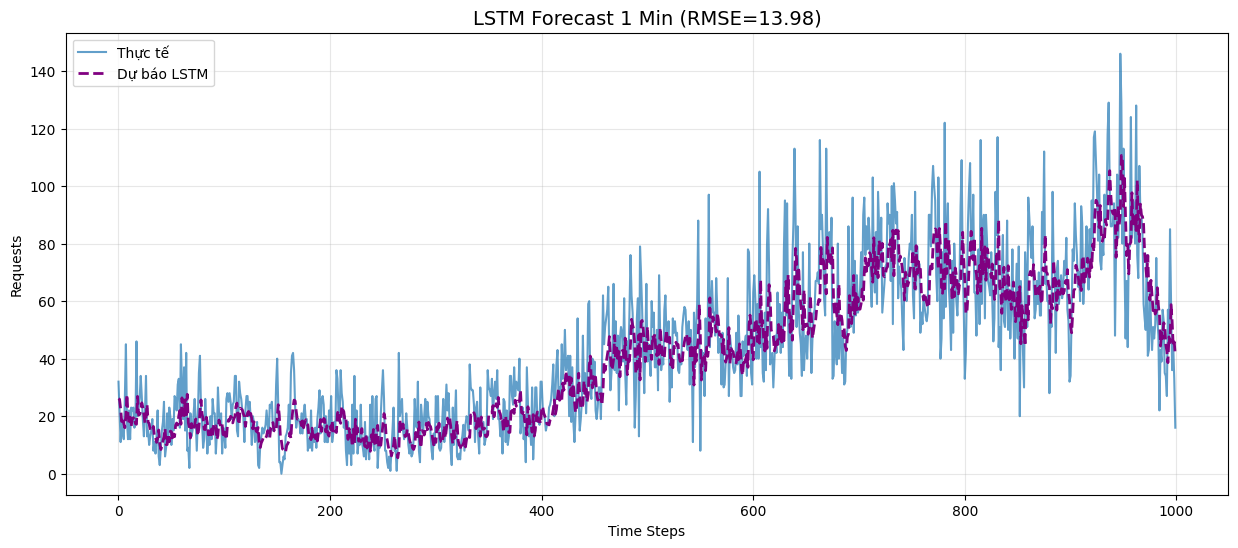

In [ ]:
# 4. Dự báo & Đánh giá
print("Đang dự báo...")
test_predict = model_final.predict(X_test)
test_predict_inv = scaler_full.inverse_transform(test_predict)
y_test_inv = scaler_full.inverse_transform([y_test])

y_true = y_test_inv[0]
y_pred = test_predict_inv[:, 0]

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mask = y_true > 0
mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

print(f"--- KẾT QUẢ LSTM (Refitted - 1 Phút) ---")
print(f"1. MAE:  {mae:.2f}")
print(f"2. MSE:  {mse:.2f}")
print(f"3. RMSE: {rmse:.2f}")
print(f"4. MAPE: {mape:.2f}%")

# Vẽ hình
plt.figure(figsize=(15, 6))
limit = 1000 # Vẽ nhiều hơn vì 1 phút rất dày
plt.plot(y_true[:limit], label='Thực tế', color='#1f77b4', alpha=0.7)
plt.plot(y_pred[:limit], label='Dự báo LSTM', color='purple', linewidth=2, linestyle='--')
plt.title(f'LSTM Forecast 1 Min (RMSE={rmse:.2f})', fontsize=14)
plt.xlabel('Time Steps')
plt.ylabel('Requests')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# --- 1. Lấy dữ liệu 15 phút ---
df_lstm_15m = df_15m.copy()
if df_lstm_15m.index.tz is not None:
    df_lstm_15m.index = df_lstm_15m.index.tz_localize(None)

dataset_15m = df_lstm_15m[['requests']].values.astype('float32')

# --- 2. Xác định điểm cắt ---
VALID_START_DATE = '1995-08-16 00:00:00'
TEST_START_DATE = '1995-08-23 00:00:00'

idx_valid = len(df_lstm_15m[df_lstm_15m.index < VALID_START_DATE])
idx_test = len(df_lstm_15m[df_lstm_15m.index < TEST_START_DATE])

print(f"Cắt Valid tại dòng: {idx_valid}")
print(f"Cắt Test tại dòng:  {idx_test}")

Cắt Valid tại dòng: 4416
Cắt Test tại dòng:  5088


In [ ]:
print("PHA 1: Tuning trên tập Valid...")

# 1. Chuẩn hóa
scaler_sub = MinMaxScaler(feature_range=(0, 1))
train_sub = dataset_15m[:idx_valid]
valid = dataset_15m[idx_valid:idx_test]

train_sub_scaled = scaler_sub.fit_transform(train_sub)
valid_scaled = scaler_sub.transform(valid)

# 2. Tạo Window (Look back 4 = 1 tiếng quá khứ)
look_back = 4
X_sub, y_sub = create_dataset(train_sub_scaled, look_back)
X_val, y_val = create_dataset(valid_scaled, look_back)

X_sub = np.reshape(X_sub, (X_sub.shape[0], X_sub.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

# 3. Tuning
model_tuning = Sequential()
model_tuning.add(LSTM(100, return_sequences=False, input_shape=(look_back, 1)))
model_tuning.add(Dense(1))
model_tuning.compile(loss='mean_squared_error', optimizer='adam')

# Tăng patience lên vì dữ liệu 15p ít nhiễu hơn
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Tăng max epochs lên 100 vì dữ liệu ít
model_tuning.fit(X_sub, y_sub,
                 validation_data=(X_val, y_val),
                 epochs=100, batch_size=32, verbose=0, # Verbose 0 cho gọn
                 callbacks=[early_stop])

best_epoch_15m = early_stop.stopped_epoch if early_stop.stopped_epoch > 0 else 100
print(f"Số Epoch tối ưu (15m): {best_epoch_15m}")

PHA 1: Tuning trên tập Valid...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Số Epoch tối ưu (15m): 24


In [ ]:
print(f"PHA 2: Huấn luyện lại ({best_epoch_15m} vòng)...")

# 1. Chuẩn hóa Full
scaler_full = MinMaxScaler(feature_range=(0, 1))
train_full = dataset_15m[:idx_test]
test_data = dataset_15m[idx_test:]

train_full_scaled = scaler_full.fit_transform(train_full)
test_scaled = scaler_full.transform(test_data)

# 2. Tạo dataset Full
X_train_full, y_train_full = create_dataset(train_full_scaled, look_back)
X_test, y_test = create_dataset(test_scaled, look_back)

X_train_full = np.reshape(X_train_full, (X_train_full.shape[0], X_train_full.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# 3. Train Final
model_final = Sequential()
model_final.add(LSTM(100, return_sequences=False, input_shape=(look_back, 1)))
model_final.add(Dense(1))
model_final.compile(loss='mean_squared_error', optimizer='adam')

model_final.fit(X_train_full, y_train_full, epochs=best_epoch_15m, batch_size=32, verbose=1)

🚀 [15 PHÚT] PHA 2: Huấn luyện lại (24 vòng)...
Epoch 1/24


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0055
Epoch 2/24
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013
Epoch 3/24
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0012
Epoch 4/24
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0011
Epoch 5/24
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0011
Epoch 6/24
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0010
Epoch 7/24
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0010
Epoch 8/24
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.8231e-04
Epoch 9/24
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.6285e-04
Epoch 10/24
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.4757e-04
Epoch 11/24
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.3557e-04
Epoch 12/24
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.2638e-04
Epoch 13/24
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.1961e-04
Epoch 14/24
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.1485e-04
Epoch 15/24
159/159 ━━━━━━━━━━━━━━━━━━━━

Đang dự báo...
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
--- KẾT QUẢ LSTM (Refitted - 15 Phút) ---
1. MAE:  93.41
2. MSE:  16310.27
3. RMSE: 127.71
4. MAPE: 17.05%


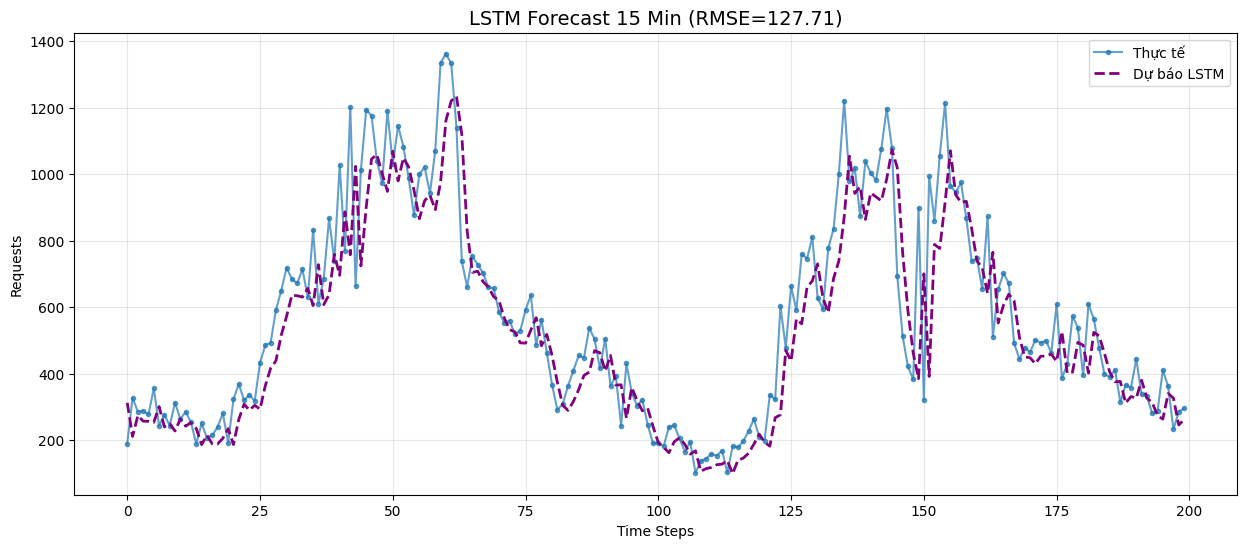

In [ ]:
# 4. Dự báo & Đánh giá
print("Đang dự báo...")
test_predict = model_final.predict(X_test)
test_predict_inv = scaler_full.inverse_transform(test_predict)
y_test_inv = scaler_full.inverse_transform([y_test])

y_true = y_test_inv[0]
y_pred = test_predict_inv[:, 0]

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mask = y_true > 0
mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

print(f"--- KẾT QUẢ LSTM (Refitted - 15 Phút) ---")
print(f"1. MAE:  {mae:.2f}")
print(f"2. MSE:  {mse:.2f}")
print(f"3. RMSE: {rmse:.2f}")
print(f"4. MAPE: {mape:.2f}%")

# Vẽ hình
plt.figure(figsize=(15, 6))
limit = 200 # Ít điểm hơn để nhìn rõ
plt.plot(y_true[:limit], label='Thực tế', color='#1f77b4', marker='o', markersize=3, alpha=0.7)
plt.plot(y_pred[:limit], label='Dự báo LSTM', color='purple', linewidth=2, linestyle='--')
plt.title(f'LSTM Forecast 15 Min (RMSE={rmse:.2f})', fontsize=14)
plt.xlabel('Time Steps')
plt.ylabel('Requests')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

***Dự đoán tải trên mô hình ARIMA cho 3 khung: 1 phút, 5 phút, 15 phút***

In [4]:
!pip install pmdarima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Lấy dữ liệu 15 phút
df_arima = df_15m.copy()
if df_arima.index.tz is not None:
    df_arima.index = df_arima.index.tz_localize(None)

# 2. Chia tập theo chiến thuật Refitting
# Valid từ 16/08, Test từ 23/08
VALID_START_DATE = '1995-08-16 00:00:00'
TEST_START_DATE = '1995-08-23 00:00:00'

# Tập Test (để chấm điểm cuối cùng)
test_arima = df_arima[df_arima.index >= TEST_START_DATE]

# Tập Train Full (Dùng cho Pha 2)
train_full_arima = df_arima[df_arima.index < TEST_START_DATE]

# Tập Train Sub (Dùng cho Pha 1 - Tìm tham số)
train_sub_arima = train_full_arima[train_full_arima.index < VALID_START_DATE]
train_sub_arima = train_sub_arima.asfreq('15min').fillna(0)
train_full_arima = train_full_arima.asfreq('15min').fillna(0)

print(f"Dataset ARIMA (15 Phút):")
print(f"- Train Sub (Tìm p,d,q): {len(train_sub_arima)}")
print(f"- Train Full (Refit):    {len(train_full_arima)}")
print(f"- Test:                  {len(test_arima)}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 38.9 MB/s eta 0:00:00
Dataset ARIMA (15 Phút):
- Train Sub (Tìm p,d,q): 4416
- Train Full (Refit):    5088
- Test:                  864


In [5]:
print(": Đang tìm tham số (p,d,q) tối ưu trên Train Sub...")

# Auto ARIMA sẽ thử sai để tìm bộ số tốt nhất (dựa trên chỉ số AIC)
# seasonal=False : Tắt mùa vụ (Chỉ chạy ARIMA)
model_auto = pm.auto_arima(train_sub_arima['requests'],
                           seasonal=False,          # <--- QUAN TRỌNG: Đây là ARIMA
                           start_p=0, start_q=0,
                           max_p=5, max_q=5,        # Tìm kiếm rộng
                           d=1,                     # Lấy sai phân bậc 1
                           trace=True,              # In ra quá trình tìm kiếm
                           error_action='ignore',
                           suppress_warnings=True)

best_order = model_auto.order
print(f"\nBộ tham số vàng tìm được: {best_order}")
# Ví dụ kết quả thường là (p,d,q) = (1,1,1) hoặc (2,1,2)

: Đang tìm tham số (p,d,q) tối ưu trên Train Sub...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=55947.516, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=55604.824, Time=0.36 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=55521.177, Time=1.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=55945.518, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=55517.617, Time=3.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=55512.756, Time=2.36 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=55518.700, Time=0.88 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=55512.597, Time=5.31 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=55510.862, Time=1.21 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=55512.627, Time=0.91 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=55504.917, Time=14.92 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=55504.306, Time=7.87 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=55514.576, Time=0.92 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept

PHA 2: Huấn luyện lại mô hình ARIMA(4, 1, 2) trên toàn bộ dữ liệu...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Đã huấn luyện xong!
Đang dự báo...
--- KẾT QUẢ ARIMA (Non-seasonal) ---
1. RMSE: 429.9162
2. MSE:  184827.9595
3. MAE:  309.0035
4. MAPE: 48.50%


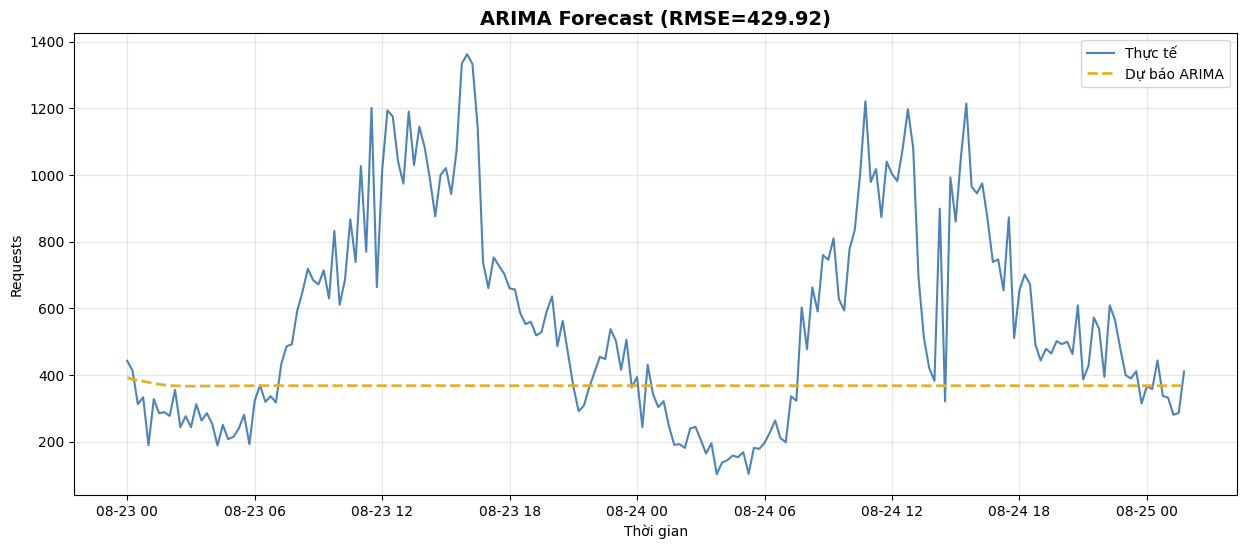

In [6]:
print(f"PHA 2: Huấn luyện lại mô hình ARIMA{best_order} trên toàn bộ dữ liệu...")

# 1. Train lại trên Train Full
# Dùng thư viện statsmodels (nhẹ hơn pmdarima cho việc fit thủ công)
model_refit = ARIMA(train_full_arima['requests'], order=best_order)
model_fit = model_refit.fit()

print("Đã huấn luyện xong!")

# 2. Dự báo trên tập Test
print("Đang dự báo...")
forecast_result = model_fit.get_forecast(steps=len(test_arima))
y_pred_arima = forecast_result.predicted_mean

# Gán index để vẽ hình
y_pred_arima.index = test_arima.index

# Xử lý số âm (Nếu có)
y_pred_arima = np.maximum(y_pred_arima, 0)

# 3. Đánh giá
y_true = test_arima['requests']

mae = mean_absolute_error(y_true, y_pred_arima)
mse = mean_squared_error(y_true, y_pred_arima)
rmse = np.sqrt(mse)
mask = y_true > 0
mape = np.mean(np.abs((y_true[mask] - y_pred_arima[mask]) / y_true[mask])) * 100

print(f"--- KẾT QUẢ ARIMA ---")
print(f"1. RMSE: {rmse:.4f}")
print(f"2. MSE:  {mse:.4f}")
print(f"3. MAE:  {mae:.4f}")
print(f"4. MAPE: {mape:.2f}%")

# 4. Vẽ biểu đồ (Đổi màu cho đẹp)
plt.figure(figsize=(15, 6))
limit = 200 # Zoom vào 200 điểm đầu

plt.plot(y_true[:limit], label='Thực tế', color='#00509d', alpha=0.7)
plt.plot(y_pred_arima[:limit], label='Dự báo ARIMA', color='#e1b12c', linewidth=2, linestyle='--') # Màu Vàng đất

plt.title(f'ARIMA Forecast (RMSE={rmse:.2f})', fontsize=14, fontweight='bold')
plt.xlabel('Thời gian')
plt.ylabel('Requests')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Lấy dữ liệu 5 phút
df_arima_5m = df_5m.copy()
if df_arima_5m.index.tz is not None:
    df_arima_5m.index = df_arima_5m.index.tz_localize(None)

# 2. Chia tập theo chiến thuật Refitting
VALID_START_DATE = '1995-08-16 00:00:00'
TEST_START_DATE = '1995-08-23 00:00:00'

# Tập Test (Chấm điểm)
test_arima_5m = df_arima_5m[df_arima_5m.index >= TEST_START_DATE]

# Tập Train Full (Dùng cho Pha 2)
train_full_arima_5m = df_arima_5m[df_arima_5m.index < TEST_START_DATE]

# Tập Train Sub (Dùng cho Pha 1 - Tìm tham số)
train_sub_arima_5m = train_full_arima_5m[train_full_arima_5m.index < VALID_START_DATE]

# --- QUAN TRỌNG: Gán tần suất 5 phút ---
train_sub_arima_5m = train_sub_arima_5m.asfreq('5min').fillna(0)
train_full_arima_5m = train_full_arima_5m.asfreq('5min').fillna(0)
# ----------------------------------------

print(f"Dataset ARIMA (5 Phút):")
print(f"- Train Sub: {len(train_sub_arima_5m)}")
print(f"- Train Full: {len(train_full_arima_5m)}")
print(f"- Test:       {len(test_arima_5m)}")

Dataset ARIMA (5 Phút):
- Train Sub: 13248
- Train Full: 15264
- Test:       2592


In [8]:
print("PHA 1: Đang tìm tham số (p,d,q) tối ưu...")

# Auto ARIMA (seasonal=False)
model_auto_5m = pm.auto_arima(train_sub_arima_5m['requests'],
                              seasonal=False,          # Tắt mùa vụ
                              start_p=0, start_q=0,
                              max_p=5, max_q=5,
                              d=1,
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True)

best_order_5m = model_auto_5m.order
print(f"\nBộ tham số vàng (5 phút): {best_order_5m}")

PHA 1: Đang tìm tham số (p,d,q) tối ưu...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=144601.368, Time=0.44 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=142949.529, Time=1.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=141616.654, Time=3.70 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=144599.369, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=141289.388, Time=9.91 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=141288.971, Time=13.57 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=142198.114, Time=1.28 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=141287.168, Time=18.88 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=141734.543, Time=3.21 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=141288.667, Time=31.42 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=141287.516, Time=33.64 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=141293.082, Time=15.22 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=141554.891, Time=3.79 sec
 ARIMA(4,1,2)(0,0,0)[0] in

PHA 2: Huấn luyện lại ARIMA(3, 1, 1) trên toàn bộ dữ liệu...
✅ Đã huấn luyện xong!
⏳ Đang dự báo...
--- KẾT QUẢ ARIMA (5 Phút) ---
1. RMSE: 142.0753
2. MSE:  20185.3954
3. MAE:  102.7722
4. MAPE: 58.80%


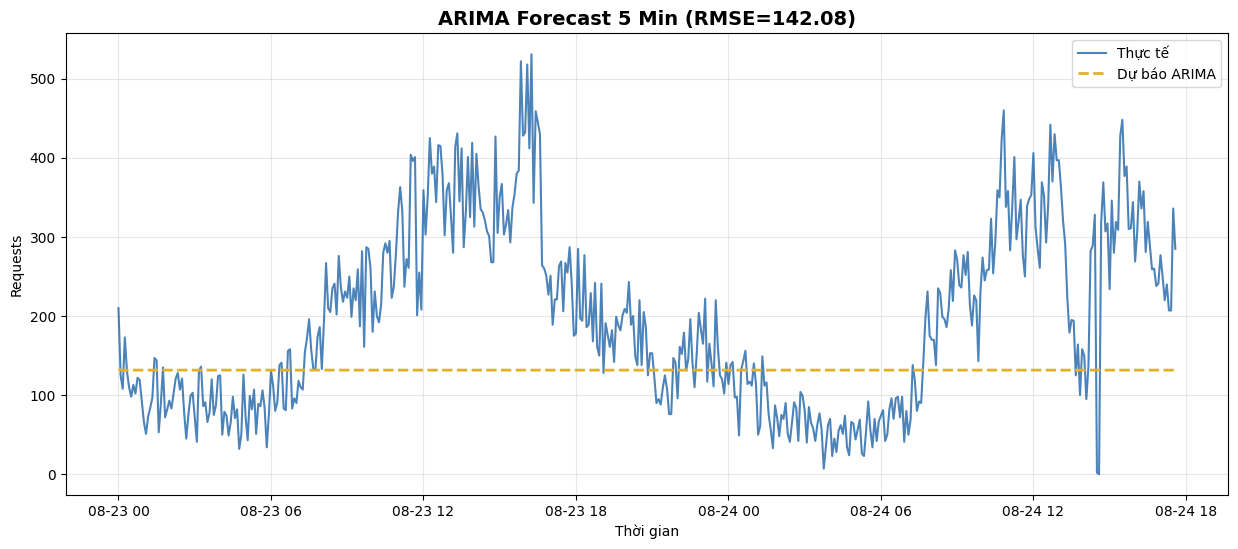

In [9]:
print(f"PHA 2: Huấn luyện lại ARIMA{best_order_5m} trên toàn bộ dữ liệu...")

# 1. Train lại trên Train Full
model_refit_5m = ARIMA(train_full_arima_5m['requests'], order=best_order_5m)
model_fit_5m = model_refit_5m.fit()

print("✅ Đã huấn luyện xong!")

# 2. Dự báo
print("⏳ Đang dự báo...")
forecast_result_5m = model_fit_5m.get_forecast(steps=len(test_arima_5m))
y_pred_5m = forecast_result_5m.predicted_mean

# Gán index và xử lý số âm
y_pred_5m.index = test_arima_5m.index
y_pred_5m = np.maximum(y_pred_5m, 0)

# 3. Đánh giá
y_true_5m = test_arima_5m['requests']

mae_5m = mean_absolute_error(y_true_5m, y_pred_5m)
mse_5m = mean_squared_error(y_true_5m, y_pred_5m)
rmse_5m = np.sqrt(mse_5m)
mask = y_true_5m > 0
mape_5m = np.mean(np.abs((y_true_5m[mask] - y_pred_5m[mask]) / y_true_5m[mask])) * 100

print(f"--- KẾT QUẢ ARIMA (5 Phút) ---")
print(f"1. RMSE: {rmse_5m:.4f}")
print(f"2. MSE:  {mse_5m:.4f}")
print(f"3. MAE:  {mae_5m:.4f}")
print(f"4. MAPE: {mape_5m:.2f}%")

# 4. Vẽ biểu đồ
plt.figure(figsize=(15, 6))
limit = 500 # Zoom 500 điểm
plt.plot(y_true_5m[:limit], label='Thực tế', color='#00509d', alpha=0.7)
plt.plot(y_pred_5m[:limit], label='Dự báo ARIMA', color='#e1b12c', linewidth=2, linestyle='--')
plt.title(f'ARIMA Forecast 5 Min (RMSE={rmse_5m:.2f})', fontsize=14, fontweight='bold')
plt.xlabel('Thời gian')
plt.ylabel('Requests')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [10]:
# 1. Lấy dữ liệu 1 phút
df_arima_1m = df_1m.copy()
if df_arima_1m.index.tz is not None:
    df_arima_1m.index = df_arima_1m.index.tz_localize(None)

# 2. Chia tập
VALID_START_DATE = '1995-08-16 00:00:00'
TEST_START_DATE = '1995-08-23 00:00:00'

test_arima_1m = df_arima_1m[df_arima_1m.index >= TEST_START_DATE]
train_full_arima_1m = df_arima_1m[df_arima_1m.index < TEST_START_DATE]
train_sub_arima_1m = train_full_arima_1m[train_full_arima_1m.index < VALID_START_DATE]

# --- Gán tần suất 1 phút ---
train_sub_arima_1m = train_sub_arima_1m.asfreq('1min').fillna(0)
train_full_arima_1m = train_full_arima_1m.asfreq('1min').fillna(0)
# ---------------------------

print(f"Dataset ARIMA (1 Phút):")
print(f"- Train Sub: {len(train_sub_arima_1m)}")
print(f"- Train Full: {len(train_full_arima_1m)}")
print(f"- Test:       {len(test_arima_1m)}")

Dataset ARIMA (1 Phút):
- Train Sub: 66240
- Train Full: 76320
- Test:       12960


In [11]:
print("PHA 1: Đang tìm tham số... (Có thể mất vài phút)")

# Auto ARIMA
model_auto_1m = pm.auto_arima(train_sub_arima_1m['requests'],
                              seasonal=False,
                              start_p=0, start_q=0,
                              max_p=5, max_q=5,
                              d=1,
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True)

best_order_1m = model_auto_1m.order
print(f"\nBộ tham số vàng (1 phút): {best_order_1m}")

🚀PHA 1: Đang tìm tham số... (Có thể mất vài phút)
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=559739.481, Time=1.80 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=549387.129, Time=1.63 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=540028.382, Time=12.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=559737.481, Time=0.58 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=536877.622, Time=26.78 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=536644.123, Time=30.30 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=545469.231, Time=2.64 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=536616.531, Time=37.93 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=542741.151, Time=6.26 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=536526.933, Time=49.60 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=541340.787, Time=8.72 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=536512.884, Time=65.19 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=540509.474, Time=8.45 sec
 ARIMA(5,1,2)(0,0

PHA 2: Huấn luyện lại ARIMA(5, 1, 1)...
Đã huấn luyện xong!
Đang dự báo...
--- KẾT QUẢ ARIMA (1 Phút) ---
1. RMSE: 30.0503
2. MSE:  903.0183
3. MAE:  21.7680
4. MAPE: 84.30%


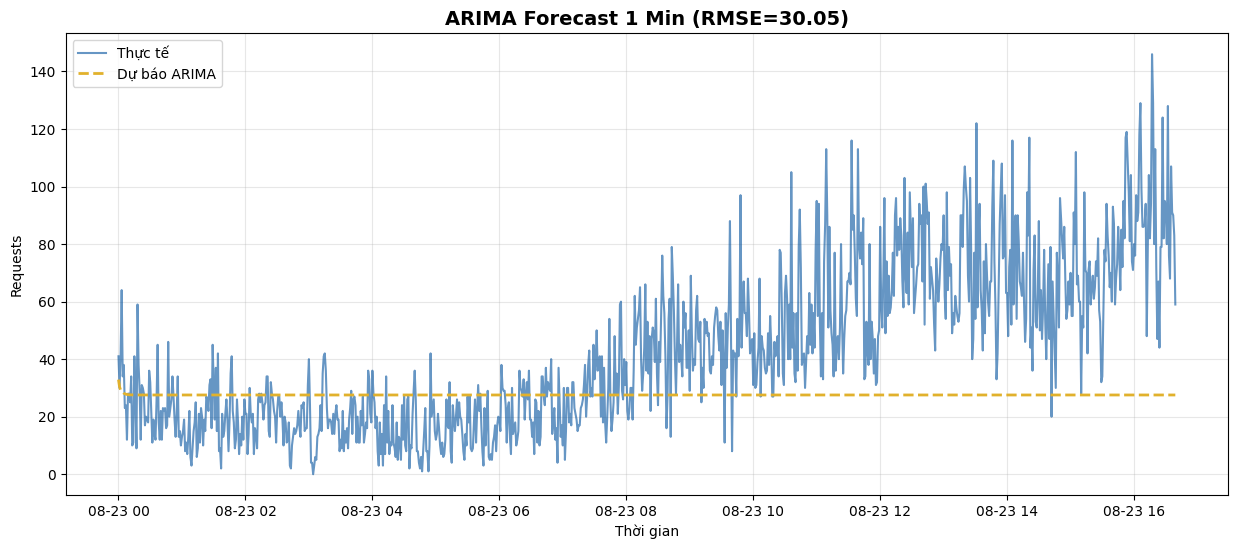

In [12]:
print(f"PHA 2: Huấn luyện lại ARIMA{best_order_1m}...")

# 1. Train lại
model_refit_1m = ARIMA(train_full_arima_1m['requests'], order=best_order_1m)
model_fit_1m = model_refit_1m.fit()

print("Đã huấn luyện xong!")

# 2. Dự báo
print("Đang dự báo...")
forecast_result_1m = model_fit_1m.get_forecast(steps=len(test_arima_1m))
y_pred_1m = forecast_result_1m.predicted_mean

y_pred_1m.index = test_arima_1m.index
y_pred_1m = np.maximum(y_pred_1m, 0)

# 3. Đánh giá
y_true_1m = test_arima_1m['requests']

mae_1m = mean_absolute_error(y_true_1m, y_pred_1m)
mse_1m = mean_squared_error(y_true_1m, y_pred_1m)
rmse_1m = np.sqrt(mse_1m)
mask = y_true_1m > 0
mape_1m = np.mean(np.abs((y_true_1m[mask] - y_pred_1m[mask]) / y_true_1m[mask])) * 100

print(f"--- KẾT QUẢ ARIMA (1 Phút) ---")
print(f"1. RMSE: {rmse_1m:.4f}")
print(f"2. MSE:  {mse_1m:.4f}")
print(f"3. MAE:  {mae_1m:.4f}")
print(f"4. MAPE: {mape_1m:.2f}%")

# 4. Vẽ biểu đồ
plt.figure(figsize=(15, 6))
limit = 1000 # Vẽ 1000 điểm vì dữ liệu 1 phút dày
plt.plot(y_true_1m[:limit], label='Thực tế', color='#00509d', alpha=0.6)
plt.plot(y_pred_1m[:limit], label='Dự báo ARIMA', color='#e1b12c', linewidth=2, linestyle='--')
plt.title(f'ARIMA Forecast 1 Min (RMSE={rmse_1m:.2f})', fontsize=14, fontweight='bold')
plt.xlabel('Thời gian')
plt.ylabel('Requests')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

***Dự đoán tải cho mô hình LightGBM theo 3 khung: 1 phút, 5 phút, 15 phút***

In [30]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# 1. Hàm tạo đặc trưng
def enhance_features(df):
    df = df.copy()

    # --- Thời gian ---
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['is_weekend'] = df.index.dayofweek.isin([5, 6]).astype(int)

    # --- Time Bins ---
    df['part_of_day'] = pd.cut(df['hour'], bins=[-1, 5, 11, 17, 23], labels=[0, 1, 2, 3]).astype(int)

    # --- Chu kỳ Sin/Cos ---
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

    # --- Lag Features ---
    for i in range(1, 4):
        df[f'lag_{i}'] = df['requests'].shift(i)

    # --- Rolling Stats ---
    window_size = 3
    df_shifted = df['requests'].shift(1) # Shift 1 để không lộ tương lai
    df['rolling_mean'] = df_shifted.rolling(window=window_size).mean()
    df['rolling_std'] = df_shifted.rolling(window=window_size).std()
    df['rolling_max'] = df_shifted.rolling(window=window_size).max()

    return df.dropna()

# 2. Áp dụng cho toàn bộ dữ liệu 1 phút
print("Đang tạo đặc trưng cho LightGBM...")
# Copy dữ liệu gốc để không ảnh hưởng
df_lgbm = df_1m.copy()
if df_lgbm.index.tz is not None:
    df_lgbm.index = df_lgbm.index.tz_localize(None)

df_final = enhance_features(df_lgbm)
print(f"Kích thước dữ liệu tổng: {df_final.shape}")

Đang tạo đặc trưng cho LightGBM...
Kích thước dữ liệu tổng: (89277, 15)


In [31]:
# Cấu hình ngày cắt
VALID_START_DATE = '1995-08-16 00:00:00'
TEST_START_DATE = '1995-08-23 00:00:00'

# 1. Tách Test (Để dành cuối cùng)
test_data = df_final[df_final.index >= TEST_START_DATE]

# 2. Tách Train Full (Dùng cho Pha 2)
train_full = df_final[df_final.index < TEST_START_DATE]

# 3. Tách Train Sub và Valid (Dùng cho Pha 1)
valid_data = train_full[train_full.index >= VALID_START_DATE]
train_sub = train_full[train_full.index < VALID_START_DATE]

# 4. Xác định Features và Target
features = ['hour', 'dayofweek', 'is_weekend', 'part_of_day',
            'hour_sin', 'hour_cos',
            'lag_1', 'lag_2', 'lag_3',
            'rolling_mean', 'rolling_std', 'rolling_max']
target = 'requests'

# Tạo các bộ dữ liệu X, y
X_train_sub, y_train_sub = train_sub[features], train_sub[target]
X_val, y_val = valid_data[features], valid_data[target]
X_train_full, y_train_full = train_full[features], train_full[target]
X_test, y_test = test_data[features], test_data[target]

print(f"Cấu hình chia tập LightGBM:")
print(f"- Train Sub:  {X_train_sub.shape}")
print(f"- Valid:      {X_val.shape}")
print(f"- Train Full: {X_train_full.shape}")
print(f"- Test:       {X_test.shape}")

Cấu hình chia tập LightGBM:
- Train Sub:  (66237, 12)
- Valid:      (10080, 12)
- Train Full: (76317, 12)
- Test:       (12960, 12)


In [32]:
print("PHA 1: Tuning trên tập Valid...")

# 1. Khởi tạo mô hình (Để n_estimators lớn để Early Stopping tự cắt)
model_tuning = lgb.LGBMRegressor(
    n_estimators=5000,      # Cho phép học tối đa 5000 cây
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    n_jobs=-1
)

# 2. Huấn luyện có Early Stopping
# callbacks=[lgb.early_stopping(50)] nghĩa là:
# Nếu 50 vòng liên tiếp mà lỗi trên tập Valid không giảm -> Dừng lại.
model_tuning.fit(
    X_train_sub, y_train_sub,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=100)]
)

# 3. Lấy số vòng tối ưu
best_iter = model_tuning.best_iteration_
print(f"\nSố cây tối ưu (Best Iteration): {best_iter}")

PHA 1: Tuning trên tập Valid...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1563
[LightGBM] [Info] Number of data points in the train set: 66237, number of used features: 12
[LightGBM] [Info] Start training from score 39.019808
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 13.2836	valid_0's l2: 176.455
Early stopping, best iteration is:
[56]	valid_0's rmse: 13.2404	valid_0's l2: 175.309

Số cây tối ưu (Best Iteration): 56


In [33]:
print(f"PHA 2: Huấn luyện lại trên toàn bộ Train ({best_iter} cây)...")

start_time = time.time()

# 1. Khởi tạo mô hình Final
# Lưu ý: Set n_estimators = best_iter
model_final = lgb.LGBMRegressor(
    n_estimators=best_iter,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    n_jobs=-1
)

# 2. Huấn luyện trên Train Full (Không cần Valid nữa)
model_final.fit(X_train_full, y_train_full)

train_time = time.time() - start_time
print(f"Huấn luyện xong trong: {train_time:.2f} giây")

PHA 2: Huấn luyện lại trên toàn bộ Train (56 cây)...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1563
[LightGBM] [Info] Number of data points in the train set: 76317, number of used features: 12
[LightGBM] [Info] Start training from score 38.455403
Huấn luyện xong trong: 0.51 giây


Đang dự báo...
--- KẾT QUẢ LIGHTGBM (Khung - 1 Phút) ---
1. RMSE: 14.2722
2. MSE:  203.6967
3. MAE:  10.8415
4. MAPE: 49.45%


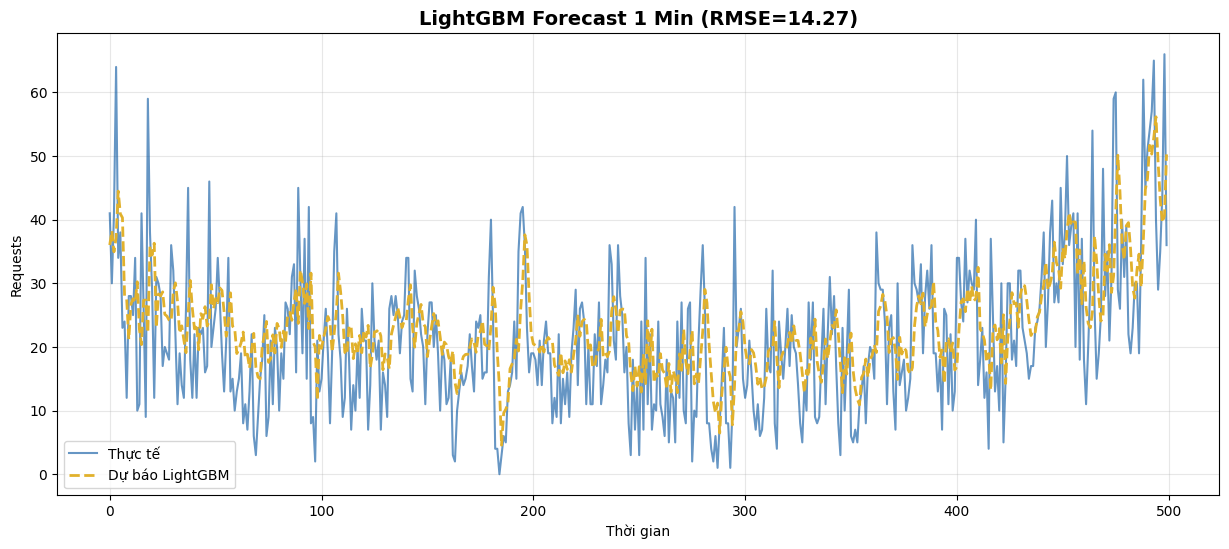

In [34]:
# 1. Dự báo
print("Đang dự báo...")
preds = model_final.predict(X_test)
# Chặn số âm (Requests không thể âm)
preds = np.maximum(preds, 0)

# 2. Đánh giá
mae = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)

mask = y_test > 0
mape = np.mean(np.abs((y_test[mask] - preds[mask]) / y_test[mask])) * 100

print(f"--- KẾT QUẢ LIGHTGBM (Khung - 1 Phút) ---")
print(f"1. RMSE: {rmse:.4f}")
print(f"2. MSE:  {mse:.4f}")
print(f"3. MAE:  {mae:.4f}")
print(f"4. MAPE: {mape:.2f}%")

# 3. Vẽ biểu đồ
plt.figure(figsize=(15, 6))
limit = 500 # Vẽ 500 điểm đầu tiên
plt.plot(y_test.values[:limit], label='Thực tế', color='#00509d', alpha=0.6)
plt.plot(preds[:limit], label='Dự báo LightGBM', color='#e1b12c', linewidth=2, linestyle='--')
plt.title(f'LightGBM Forecast 1 Min (RMSE={rmse:.2f})', fontsize=14, fontweight='bold')
plt.xlabel('Thời gian')
plt.ylabel('Requests')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [35]:
# 1. Áp dụng hàm tạo đặc trưng (đã khai báo ở trên) cho dữ liệu 5 phút
print("Đang tạo đặc trưng...")

df_lgbm_5m = df_5m.copy()
if df_lgbm_5m.index.tz is not None:
    df_lgbm_5m.index = df_lgbm_5m.index.tz_localize(None)

# Gọi hàm enhance_features
df_final_5m = enhance_features(df_lgbm_5m)

print(f"Kích thước dữ liệu 5 phút: {df_final_5m.shape}")

Đang tạo đặc trưng...
Kích thước dữ liệu 5 phút: (17853, 15)


In [36]:
# Cấu hình ngày cắt
VALID_START_DATE = '1995-08-16 00:00:00'
TEST_START_DATE = '1995-08-23 00:00:00'

# 1. Chia tập
test_data_5m = df_final_5m[df_final_5m.index >= TEST_START_DATE]
train_full_5m = df_final_5m[df_final_5m.index < TEST_START_DATE]

valid_data_5m = train_full_5m[train_full_5m.index >= VALID_START_DATE]
train_sub_5m = train_full_5m[train_full_5m.index < VALID_START_DATE]

# 2. Tách Features và Target
features = ['hour', 'dayofweek', 'is_weekend', 'part_of_day',
            'hour_sin', 'hour_cos',
            'lag_1', 'lag_2', 'lag_3',
            'rolling_mean', 'rolling_std', 'rolling_max']
target = 'requests'

X_train_sub_5m, y_train_sub_5m = train_sub_5m[features], train_sub_5m[target]
X_val_5m, y_val_5m = valid_data_5m[features], valid_data_5m[target]
X_train_full_5m, y_train_full_5m = train_full_5m[features], train_full_5m[target]
X_test_5m, y_test_5m = test_data_5m[features], test_data_5m[target]

print(f"Cấu hình chia tập (5 Phút):")
print(f"- Train Sub: {X_train_sub_5m.shape}")
print(f"- Valid:     {X_val_5m.shape}")
print(f"- Refit:     {X_train_full_5m.shape}")

Cấu hình chia tập (5 Phút):
- Train Sub: (13245, 12)
- Valid:     (2016, 12)
- Refit:     (15261, 12)


In [37]:
print("PHA 1: Tuning tìm số cây tối ưu...")

model_tuning_5m = lgb.LGBMRegressor(
    n_estimators=5000,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    n_jobs=-1
)

model_tuning_5m.fit(
    X_train_sub_5m, y_train_sub_5m,
    eval_set=[(X_val_5m, y_val_5m)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=0)] # Tắt log cho gọn
)

best_iter_5m = model_tuning_5m.best_iteration_
print(f"\nSố cây tối ưu (5m): {best_iter_5m}")

PHA 1: Tuning tìm số cây tối ưu...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1607
[LightGBM] [Info] Number of data points in the train set: 13245, number of used features: 12
[LightGBM] [Info] Start training from score 195.085315
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	valid_0's rmse: 44.7049	valid_0's l2: 1998.52

Số cây tối ưu (5m): 64


PHA 2: Huấn luyện lại (64 cây)...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1607
[LightGBM] [Info] Number of data points in the train set: 15261, number of used features: 12
[LightGBM] [Info] Start training from score 192.264662
Train xong trong: 0.14s
--- KẾT QUẢ LIGHTGBM (Khung - 5 Phút) ---
1. RMSE: 46.7376
2. MAE:  35.1813
3. MAPE: 30.65%


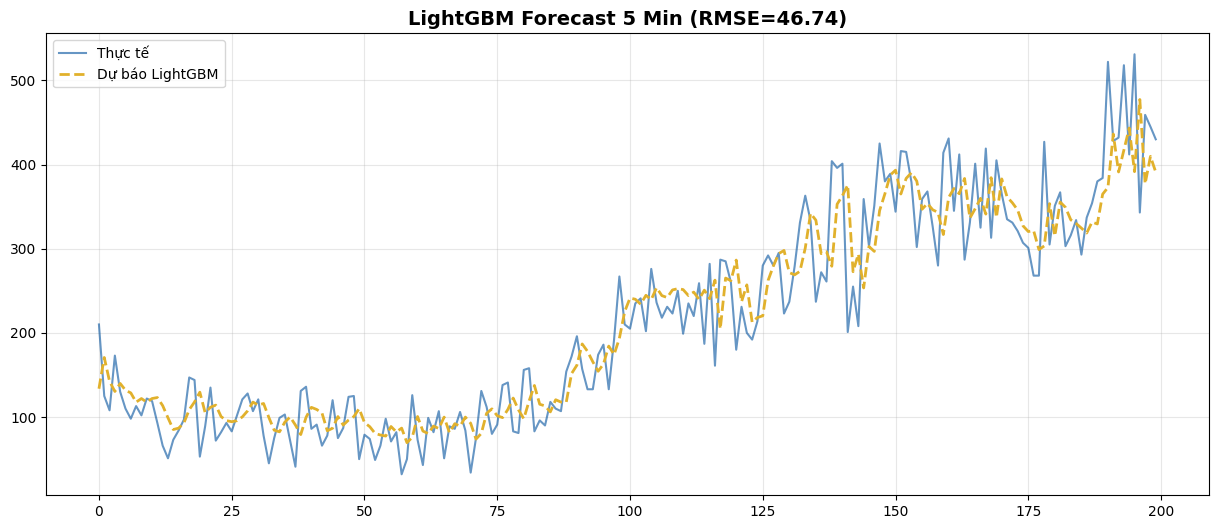

In [38]:
print(f"PHA 2: Huấn luyện lại ({best_iter_5m} cây)...")
start_time = time.time()

# 1. Train lại trên toàn bộ dữ liệu
model_final_5m = lgb.LGBMRegressor(
    n_estimators=best_iter_5m,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    n_jobs=-1
)

model_final_5m.fit(X_train_full_5m, y_train_full_5m)
print(f"Train xong trong: {time.time() - start_time:.2f}s")

# 2. Dự báo
preds_5m = model_final_5m.predict(X_test_5m)
preds_5m = np.maximum(preds_5m, 0)

# 3. Đánh giá
mae_5m = mean_absolute_error(y_test_5m, preds_5m)
mse_5m = mean_squared_error(y_test_5m, preds_5m)
rmse_5m = np.sqrt(mse_5m)
mask = y_test_5m > 0
mape_5m = np.mean(np.abs((y_test_5m[mask] - preds_5m[mask]) / y_test_5m[mask])) * 100

print(f"--- KẾT QUẢ LIGHTGBM (Khung - 5 Phút) ---")
print(f"1. RMSE: {rmse_5m:.4f}")
print(f"2. MAE:  {mae_5m:.4f}")
print(f"3. MAPE: {mape_5m:.2f}%")

# 4. Vẽ biểu đồ
plt.figure(figsize=(15, 6))
limit = 200
plt.plot(y_test_5m.values[:limit], label='Thực tế', color='#00509d', alpha=0.6)
plt.plot(preds_5m[:limit], label='Dự báo LightGBM', color='#e1b12c', linewidth=2, linestyle='--')
plt.title(f'LightGBM Forecast 5 Min (RMSE={rmse_5m:.2f})', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [39]:
print("Đang tạo đặc trưng...")

df_lgbm_15m = df_15m.copy()
if df_lgbm_15m.index.tz is not None:
    df_lgbm_15m.index = df_lgbm_15m.index.tz_localize(None)

df_final_15m = enhance_features(df_lgbm_15m)

print(f"Kích thước dữ liệu 15 phút: {df_final_15m.shape}")

Đang tạo đặc trưng...
Kích thước dữ liệu 15 phút: (5949, 15)


In [40]:
# Ngày cắt giữ nguyên
VALID_START_DATE = '1995-08-16 00:00:00'
TEST_START_DATE = '1995-08-23 00:00:00'

test_data_15m = df_final_15m[df_final_15m.index >= TEST_START_DATE]
train_full_15m = df_final_15m[df_final_15m.index < TEST_START_DATE]

valid_data_15m = train_full_15m[train_full_15m.index >= VALID_START_DATE]
train_sub_15m = train_full_15m[train_full_15m.index < VALID_START_DATE]

# Tách X, y
features = ['hour', 'dayofweek', 'is_weekend', 'part_of_day',
            'hour_sin', 'hour_cos',
            'lag_1', 'lag_2', 'lag_3',
            'rolling_mean', 'rolling_std', 'rolling_max']
target = 'requests'

X_train_sub_15m, y_train_sub_15m = train_sub_15m[features], train_sub_15m[target]
X_val_15m, y_val_15m = valid_data_15m[features], valid_data_15m[target]
X_train_full_15m, y_train_full_15m = train_full_15m[features], train_full_15m[target]
X_test_15m, y_test_15m = test_data_15m[features], test_data_15m[target]

print(f"Cấu hình chia tập (15 Phút):")
print(f"- Train Sub: {X_train_sub_15m.shape}")
print(f"- Valid:     {X_val_15m.shape}")

Cấu hình chia tập (15 Phút):
- Train Sub: (4413, 12)
- Valid:     (672, 12)


In [41]:
print("PHA 1: Tuning...")

model_tuning_15m = lgb.LGBMRegressor(
    n_estimators=5000,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    n_jobs=-1
)

model_tuning_15m.fit(
    X_train_sub_15m, y_train_sub_15m,
    eval_set=[(X_val_15m, y_val_15m)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=0)]
)

best_iter_15m = model_tuning_15m.best_iteration_
print(f"\nSố cây tối ưu (15m): {best_iter_15m}")

PHA 1: Tuning...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1607
[LightGBM] [Info] Number of data points in the train set: 4413, number of used features: 12
[LightGBM] [Info] Start training from score 585.079085
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[73]	valid_0's rmse: 101.768	valid_0's l2: 10356.8

Số cây tối ưu (15m): 73


PHA 2: Huấn luyện lại (73 cây)...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1607
[LightGBM] [Info] Number of data points in the train set: 5085, number of used features: 12
[LightGBM] [Info] Start training from score 576.637168
--- KẾT QUẢ LIGHTGBM (Khung - 15 Phút) ---
1. RMSE: 114.2417
2. MAE:  82.9450
3. MAPE: 17.34%


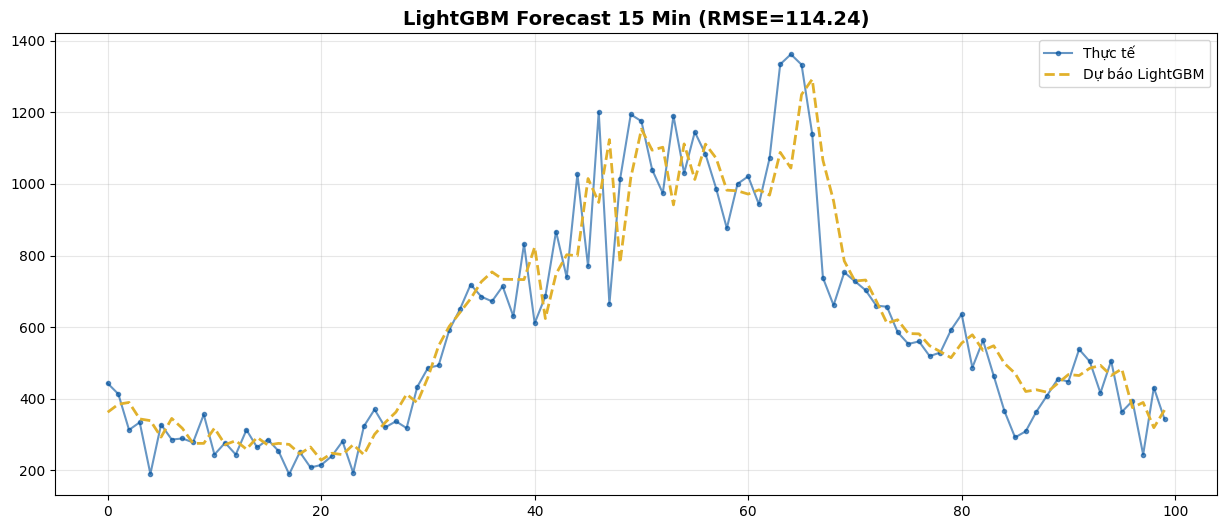

In [42]:
print(f"PHA 2: Huấn luyện lại ({best_iter_15m} cây)...")

# 1. Train lại
model_final_15m = lgb.LGBMRegressor(
    n_estimators=best_iter_15m,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    n_jobs=-1
)

model_final_15m.fit(X_train_full_15m, y_train_full_15m)

# 2. Dự báo
preds_15m = model_final_15m.predict(X_test_15m)
preds_15m = np.maximum(preds_15m, 0)

# 3. Đánh giá
mae_15m = mean_absolute_error(y_test_15m, preds_15m)
mse_15m = mean_squared_error(y_test_15m, preds_15m)
rmse_15m = np.sqrt(mse_15m)
mask = y_test_15m > 0
mape_15m = np.mean(np.abs((y_test_15m[mask] - preds_15m[mask]) / y_test_15m[mask])) * 100

print(f"--- KẾT QUẢ LIGHTGBM (Khung - 15 Phút) ---")
print(f"1. RMSE: {rmse_15m:.4f}")
print(f"2. MAE:  {mae_15m:.4f}")
print(f"3. MAPE: {mape_15m:.2f}%")

# 4. Vẽ biểu đồ
plt.figure(figsize=(15, 6))
limit = 100
plt.plot(y_test_15m.values[:limit], label='Thực tế', color='#00509d', marker='o', markersize=3, alpha=0.6)
plt.plot(preds_15m[:limit], label='Dự báo LightGBM', color='#e1b12c', linewidth=2, linestyle='--')
plt.title(f'LightGBM Forecast 15 Min (RMSE={rmse_15m:.2f})', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()